# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [102]:
# !pip install folium

In [103]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [104]:
import numpy as np
!pip install haversine
from haversine import haversine, Unit

In [105]:
!pip install wget

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [106]:
import zipfile
import pandas as pd
import mimetypes


In [107]:
train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

In [108]:
# file_type = mimetypes.guess_type(path_train)[0]
# if file_type == "application/zip":
#   path_train = "/content/train.zip"
#   with zipfile.ZipFile(path_train) as z:
#       for filename in z.namelist():
#           train_df = pd.read_csv(z.open(filename))

# path_test = "/content/test.zip"
# with zipfile.ZipFile(path_test) as z:
#     for filename in z.namelist():
#         test_df = pd.read_csv(z.open(filename))


# # path_sample = "/content/sample_submission.zip"
# # with zipfile.ZipFile(path_sample) as z:
# #     for filename in z.namelist():
# #         sample_df = pd.read_csv(z.open(filename))



Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [109]:
train_df = train_df.drop(columns=["dropoff_datetime"])
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], errors = 'coerce')


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

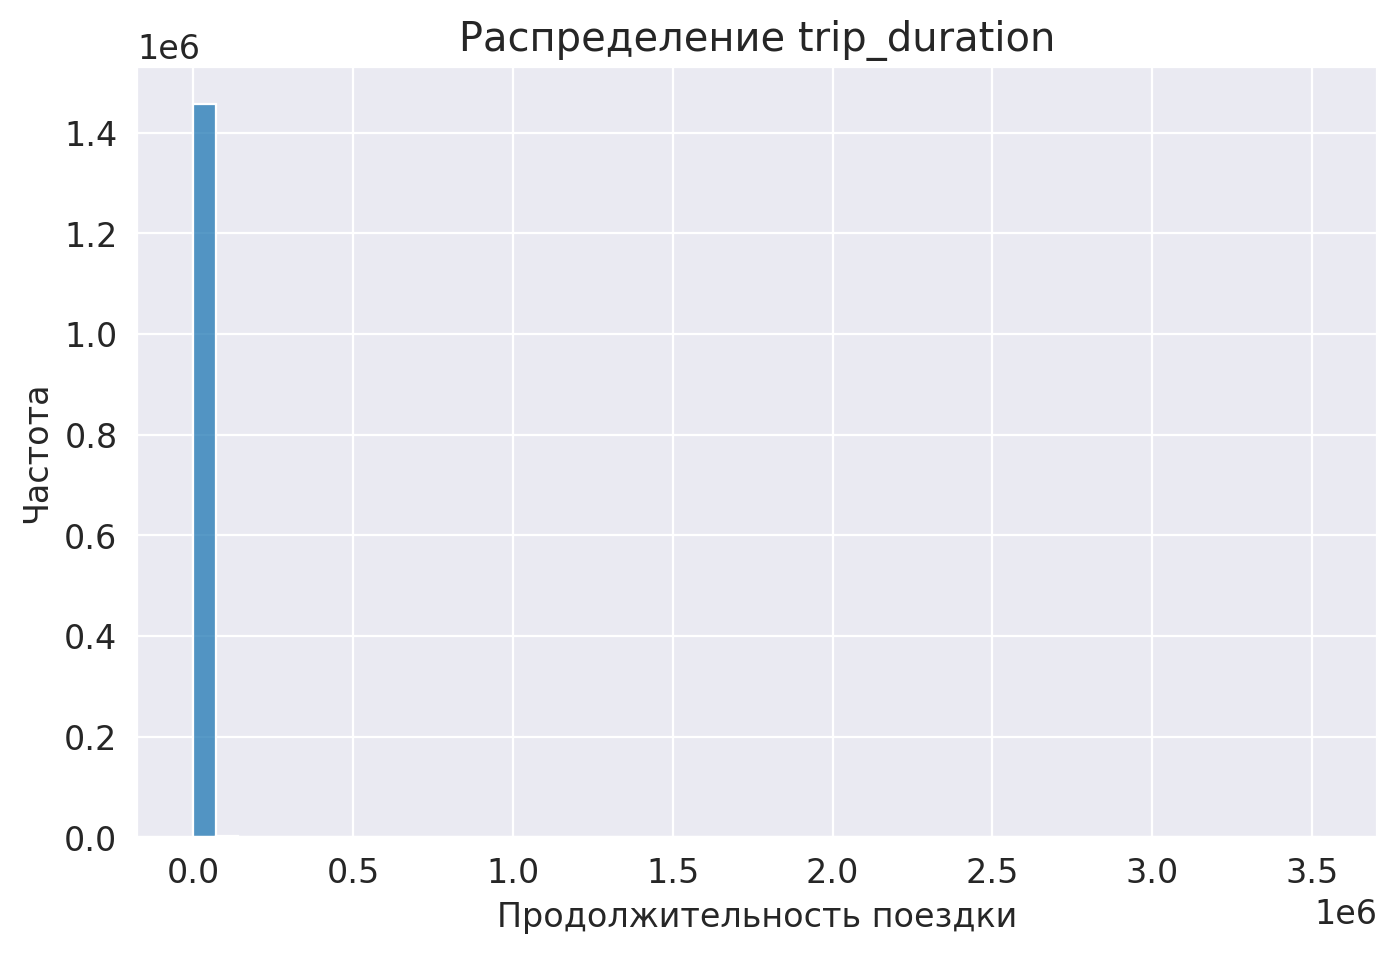

In [111]:
sns.histplot(train_df['trip_duration'], bins=50, kde=False)

plt.title('Распределение trip_duration')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Частота')

plt.show()

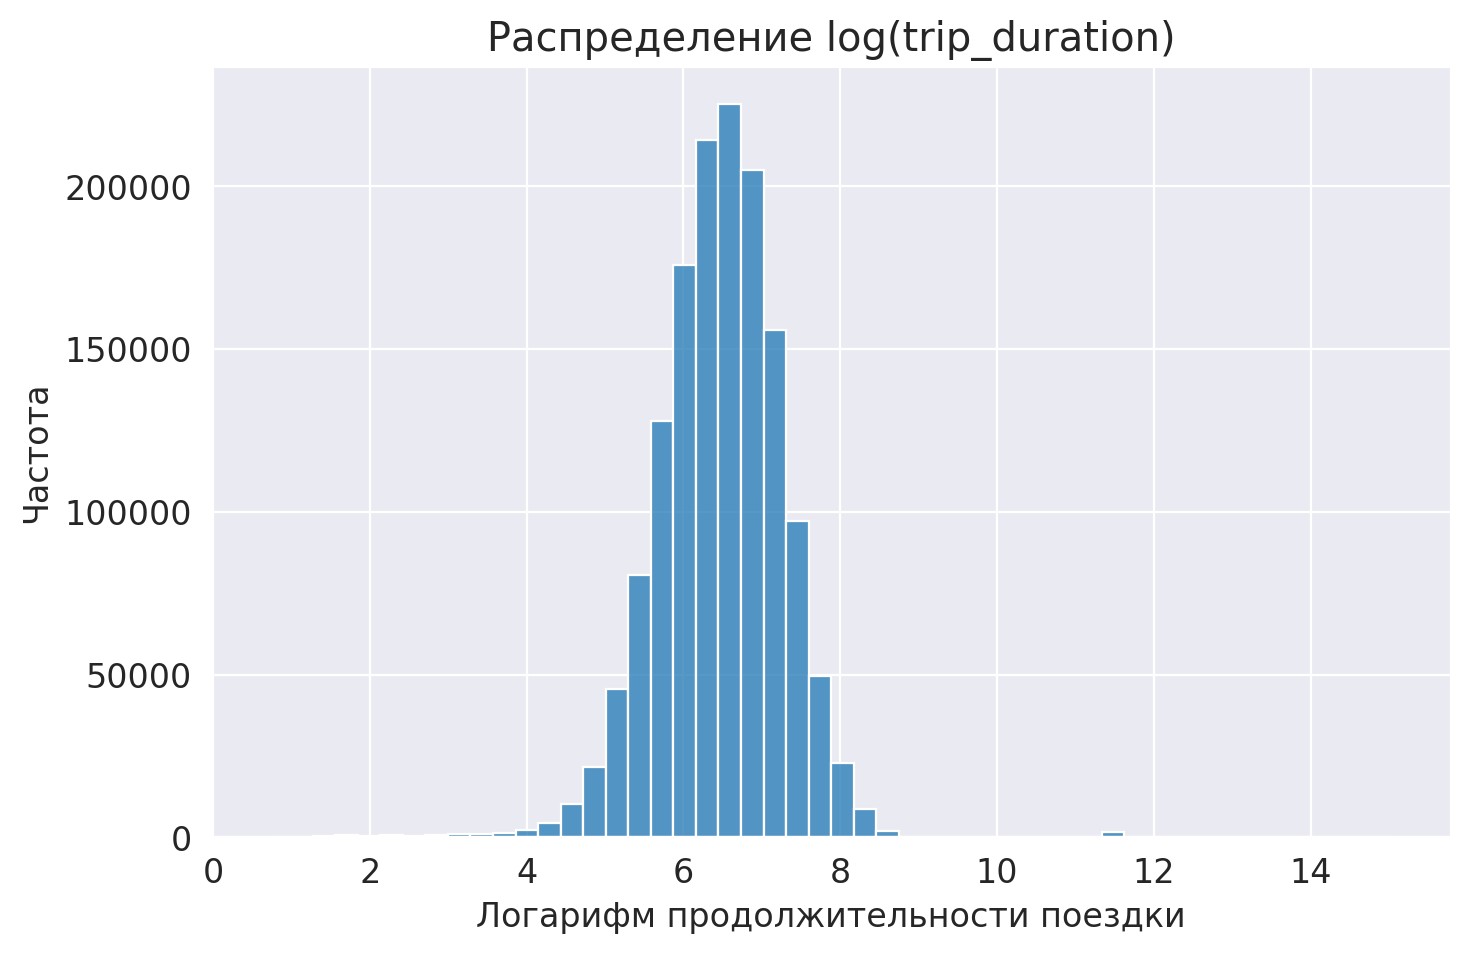

In [112]:
# Для наглядности и более детального отображения, изобразим логарифм trip_duration на гистограмме
sns.histplot(train_df['trip_duration'].apply(lambda x: np.log(x + 1)), bins=50, kde=False)

plt.title('Распределение log(trip_duration)')
plt.xlabel('Логарифм продолжительности поездки')
plt.ylabel('Частота')

plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Судя по графику логарифма переменной, наибольшее количество значений сосредоточено в районе $[e^6; e^7]$. Однако, в данных также присутствуют выбросы, которые, вероятно, являются причиной плохой наглядности первого графика.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

1) меньшая чувствительность к выбросам. Благодаря логарифмированию переменных, RMSLE меньше штрафует модель в  случае появления выбросов. Так как в наших данных есть несколько экстремально долгих поездок, это помогает повысить точность модели.

2) RMSLE фокусируется на относительных ошибках. В случае предсказания короткой поездки ошибка в 15 минут будет более критичной, чем в случае предсказания длительности более долгой поездки. Благодаря использованию функции логарифма, RMSLE штрафует модель при больших и малых значениях trip_duration по-разному, что приводит к оценке относительных, а не абсолютных ошибок.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
Не мудрствуя лукаво, подставим $a(x_i) = \exp(\hat{a}(x_i)) - 1$ во второе слагаемое и преобразуем:

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} =
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \hat{a}(x_i)\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i- \hat{a}(x_i)\big)^2} = \sqrt{MSE (X, y_i, \hat{a}(x_i))}$$

Как видим, оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [113]:
train_df['log_trip_duration'] = train_df[['trip_duration']].apply(lambda x: np.log1p(x+1))
train_df_original = train_df.copy()
#train_df = train_df.drop(columns=['trip_duration'])

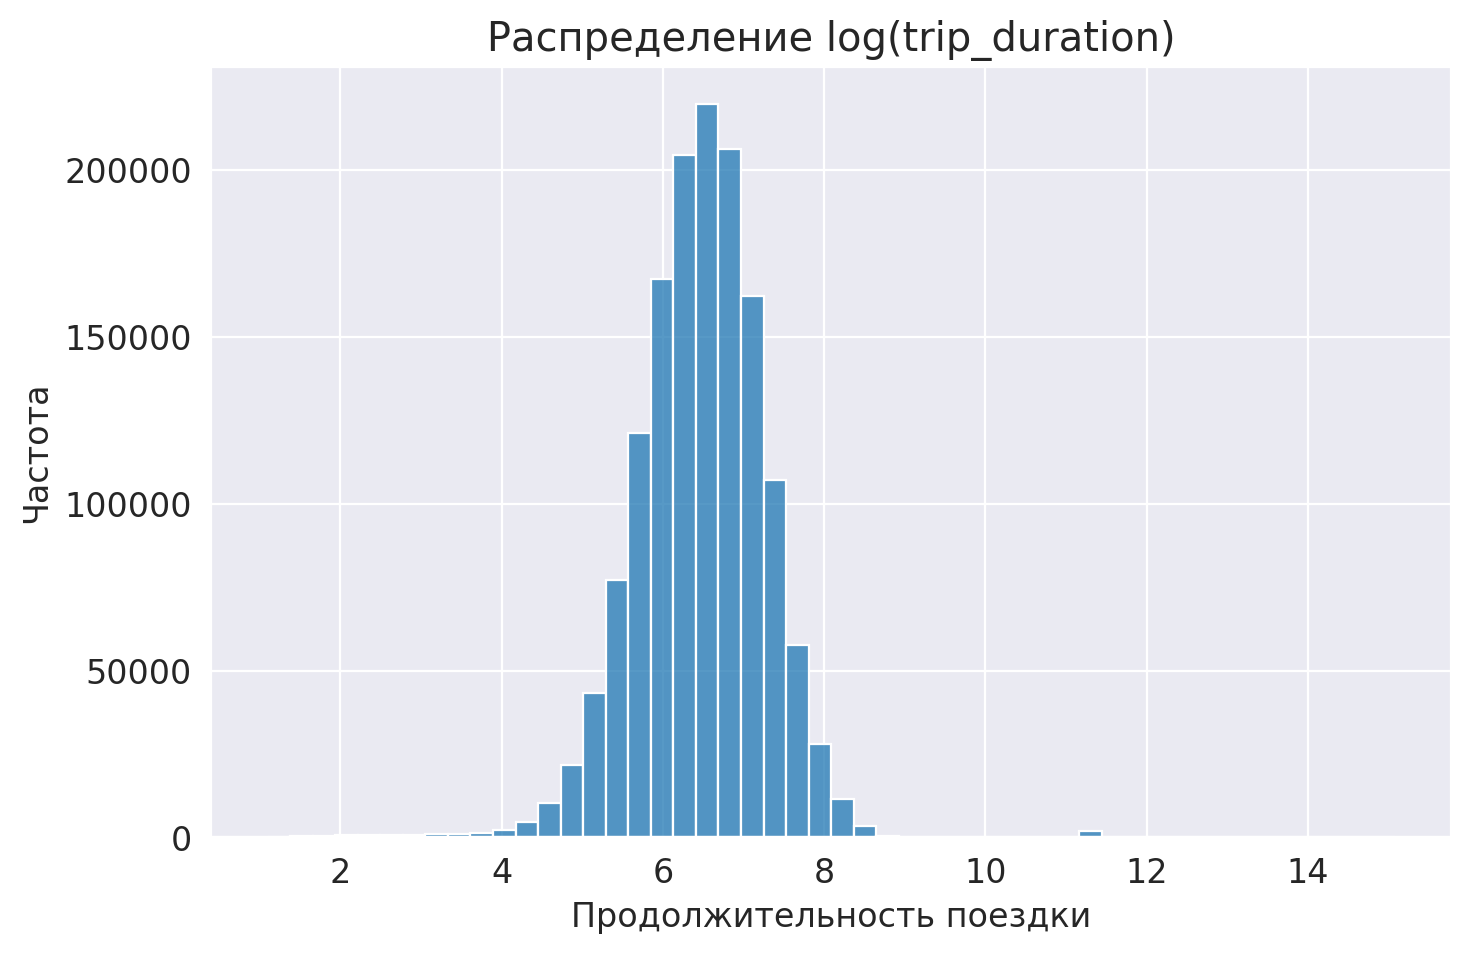

In [114]:
sns.histplot(train_df['log_trip_duration'], bins=50, kde=False)

plt.title('Распределение log(trip_duration)')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Частота')

plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

В качестве наилучшего константного предсказания используем среднее значение целевой перменной, так как это значение минимизирует среднеквадратическую ошибку.


In [115]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))

rmsle_best_const = rmsle(train_df['log_trip_duration'], np.mean(train_df['log_trip_duration']))
print(rmsle_best_const)


0.7923870986444396


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

In [116]:
import matplotlib.dates as mdates

In [117]:
train_df.head(5)

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  log_trip_duration  
0                  N            455           6.124683  
1                  N            663           6.499787  
2                  N           2124           7.661998  
3                  N            429           6.066108  
4                  N            435           6.079933

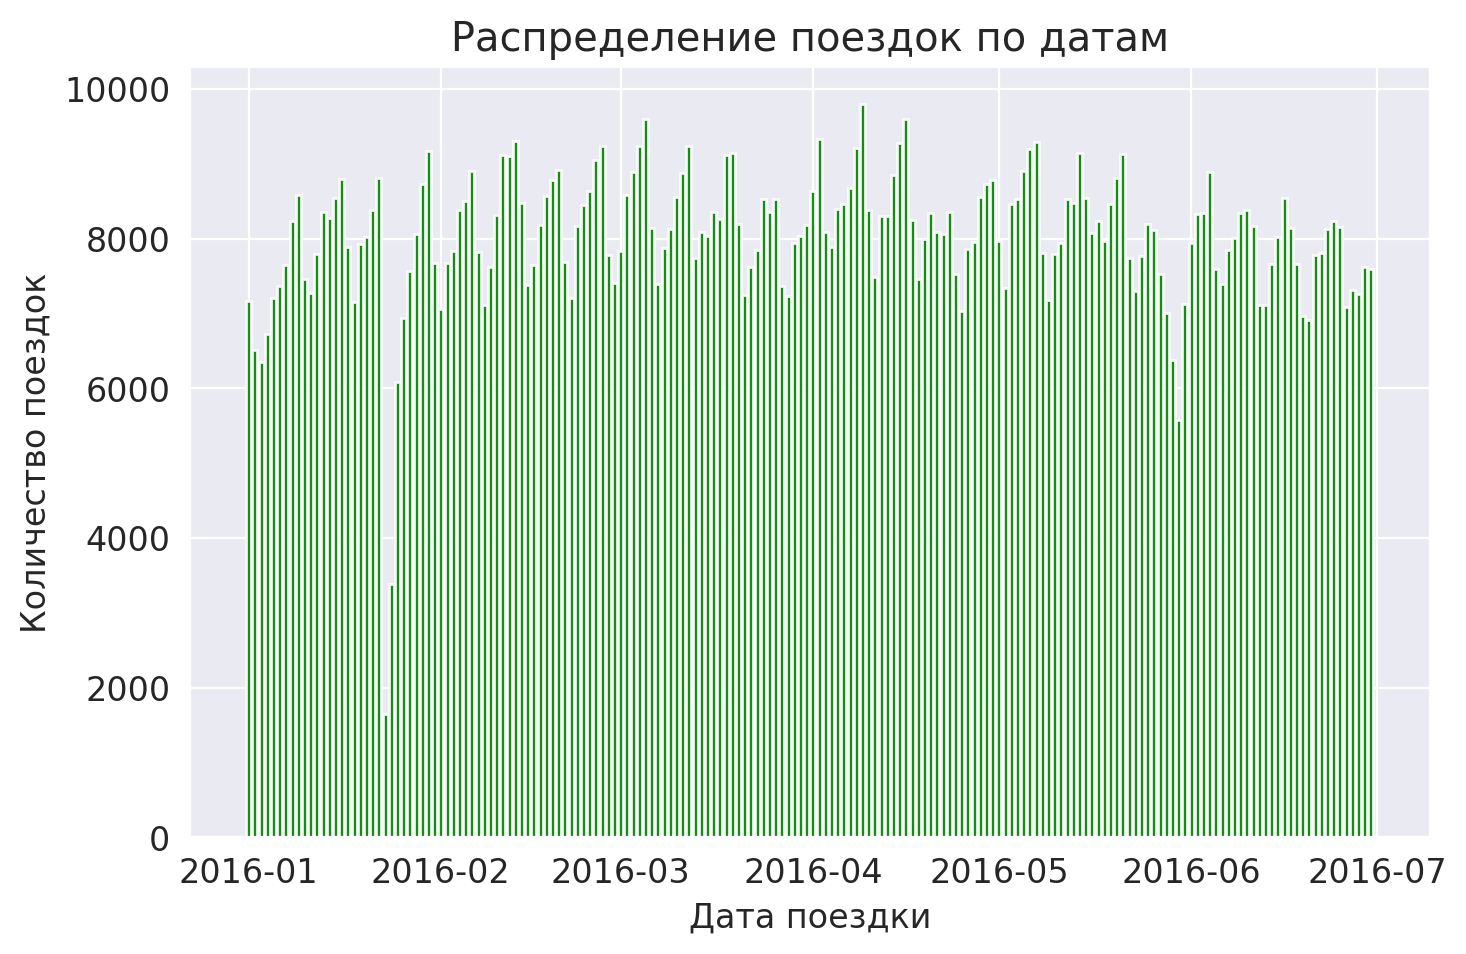

In [118]:
train_df['num_trips'] = 1
daily_trips = train_df.groupby(train_df['pickup_datetime'].dt.date)['num_trips'].sum().reset_index()
daily_trips.rename(columns={'pickup_datetime': 'date'}, inplace=True)

plt.bar(daily_trips['date'], daily_trips['num_trips'], color='g', alpha=0.9)

plt.title('Распределение поездок по датам')
plt.xlabel('Дата поездки')
plt.ylabel('Количество поездок')

plt.show()

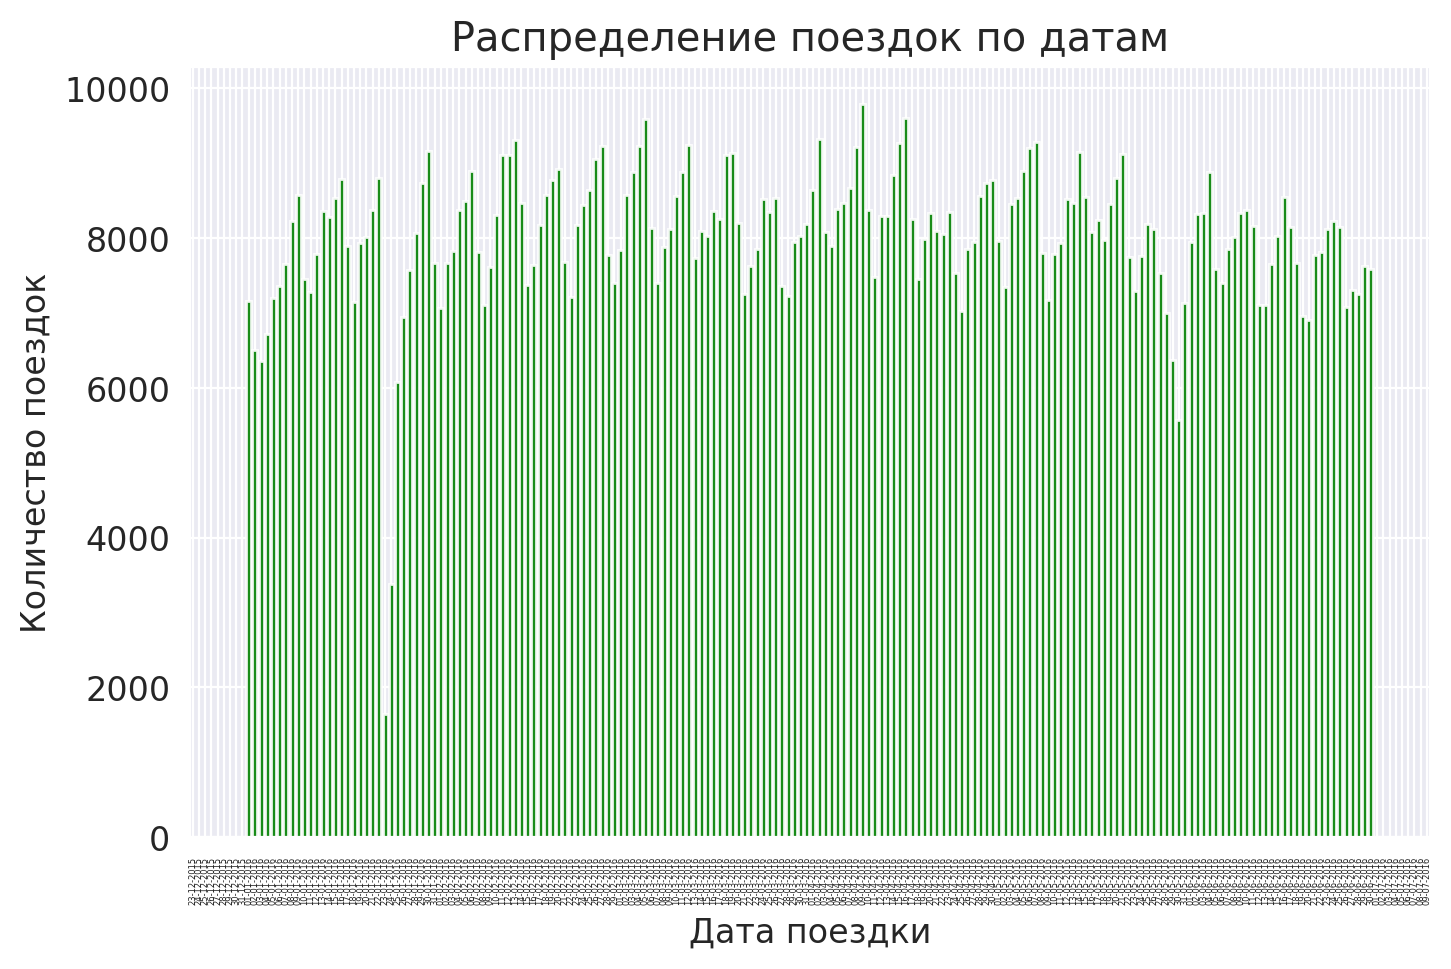

In [119]:
# Выведем на оси Х дни с датами:
train_df['num_trips'] = 1
daily_trips = train_df.groupby(train_df['pickup_datetime'].dt.date)['num_trips'].sum().reset_index()
daily_trips.rename(columns={'pickup_datetime': 'date'}, inplace=True)

plt.bar(daily_trips['date'], daily_trips['num_trips'], color='g', alpha=0.9)

plt.title('Распределение поездок по датам')
plt.xlabel('Дата поездки')
plt.ylabel('Количество поездок')

plt.xticks(rotation=90, fontsize = 3)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


plt.show()

In [120]:
# посмотрим на дни с аномально малым числом поездок
daily_trips[daily_trips['num_trips']<6000]

date  num_trips
22   2016-01-23       1648
23   2016-01-24       3383
150  2016-05-30       5570

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

1) 23 января 2016 - в Нью-Йорке прошла супер сильная снежная буря. Куча рейсов было отменено, дороги замело снегом.

2) 30 мая - на севере Манхэттена произошла стрельба.

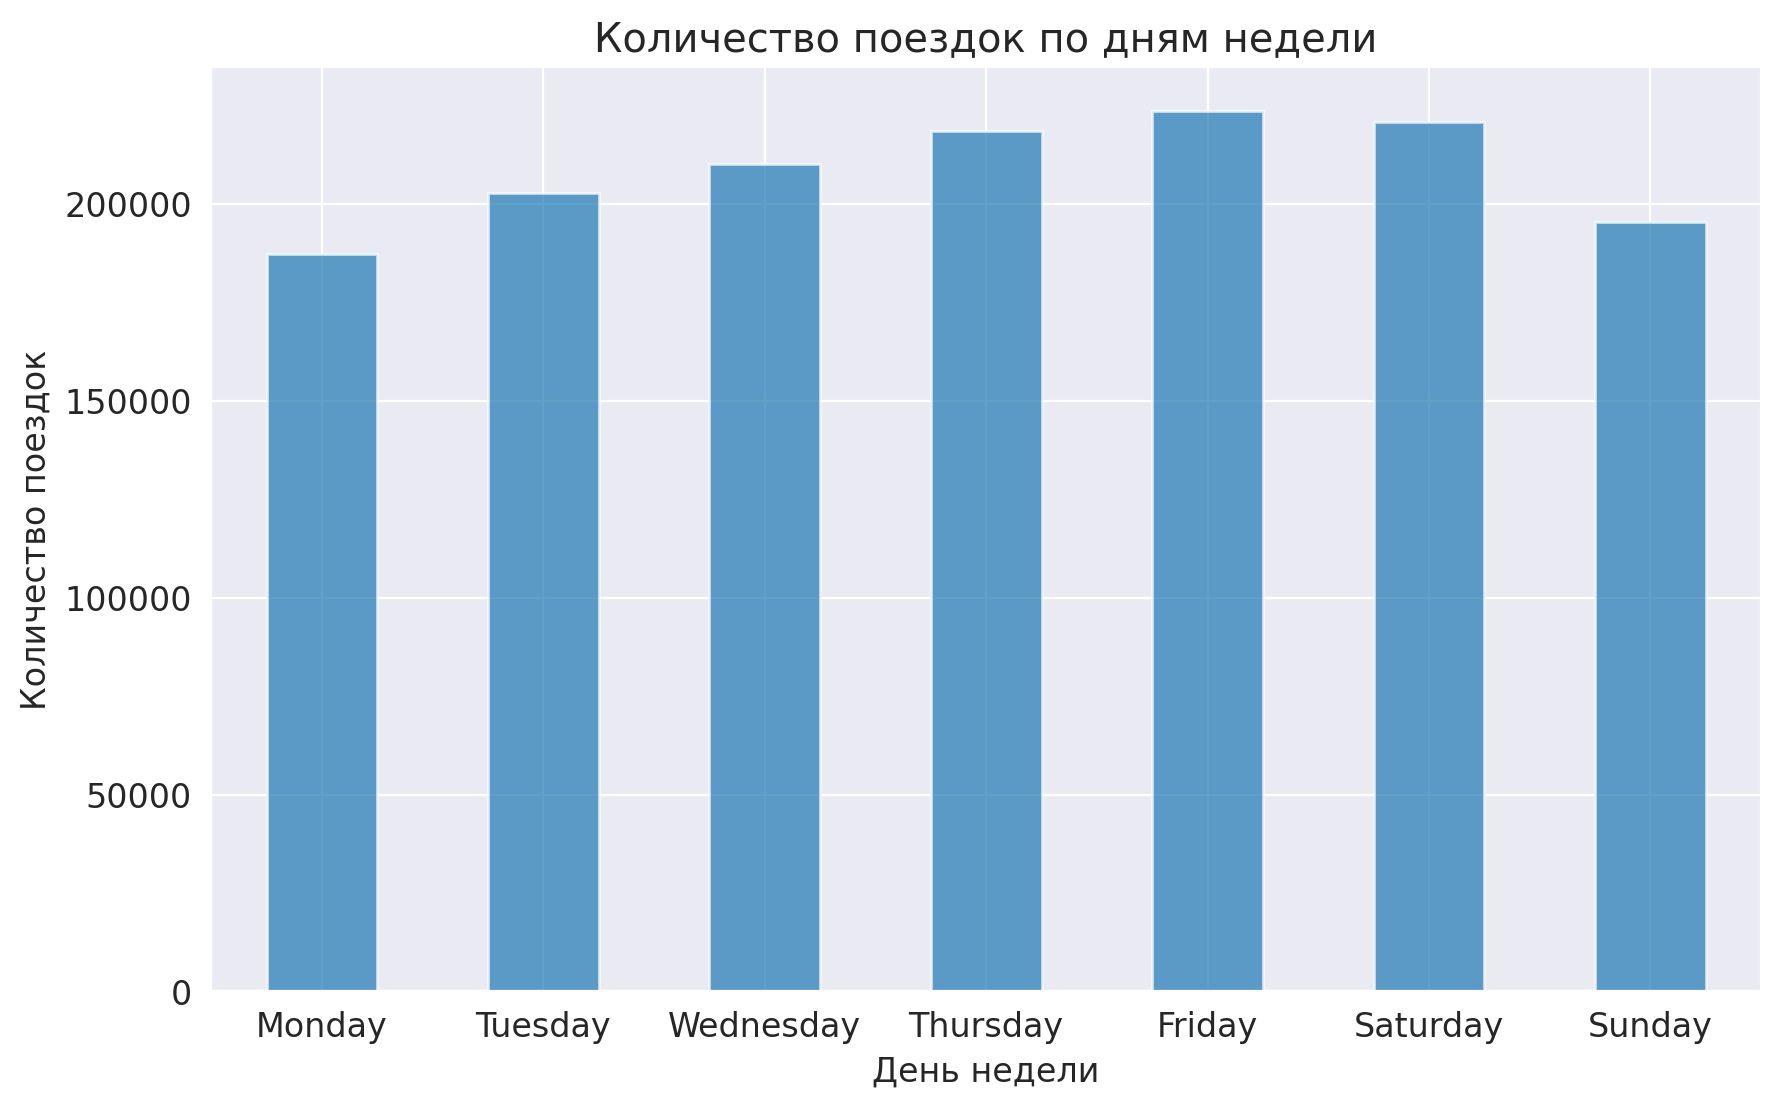

In [121]:
# график поездок по дням
train_df['day_of_week'] = train_df['pickup_datetime'].dt.day_name()
trips_by_day = train_df.groupby('day_of_week')['num_trips'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

serkut = "happy man"
plt.figure(figsize=(10, 6))
trips_by_day.plot(kind="bar", alpha=0.7)
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(rotation=0)
plt.show()

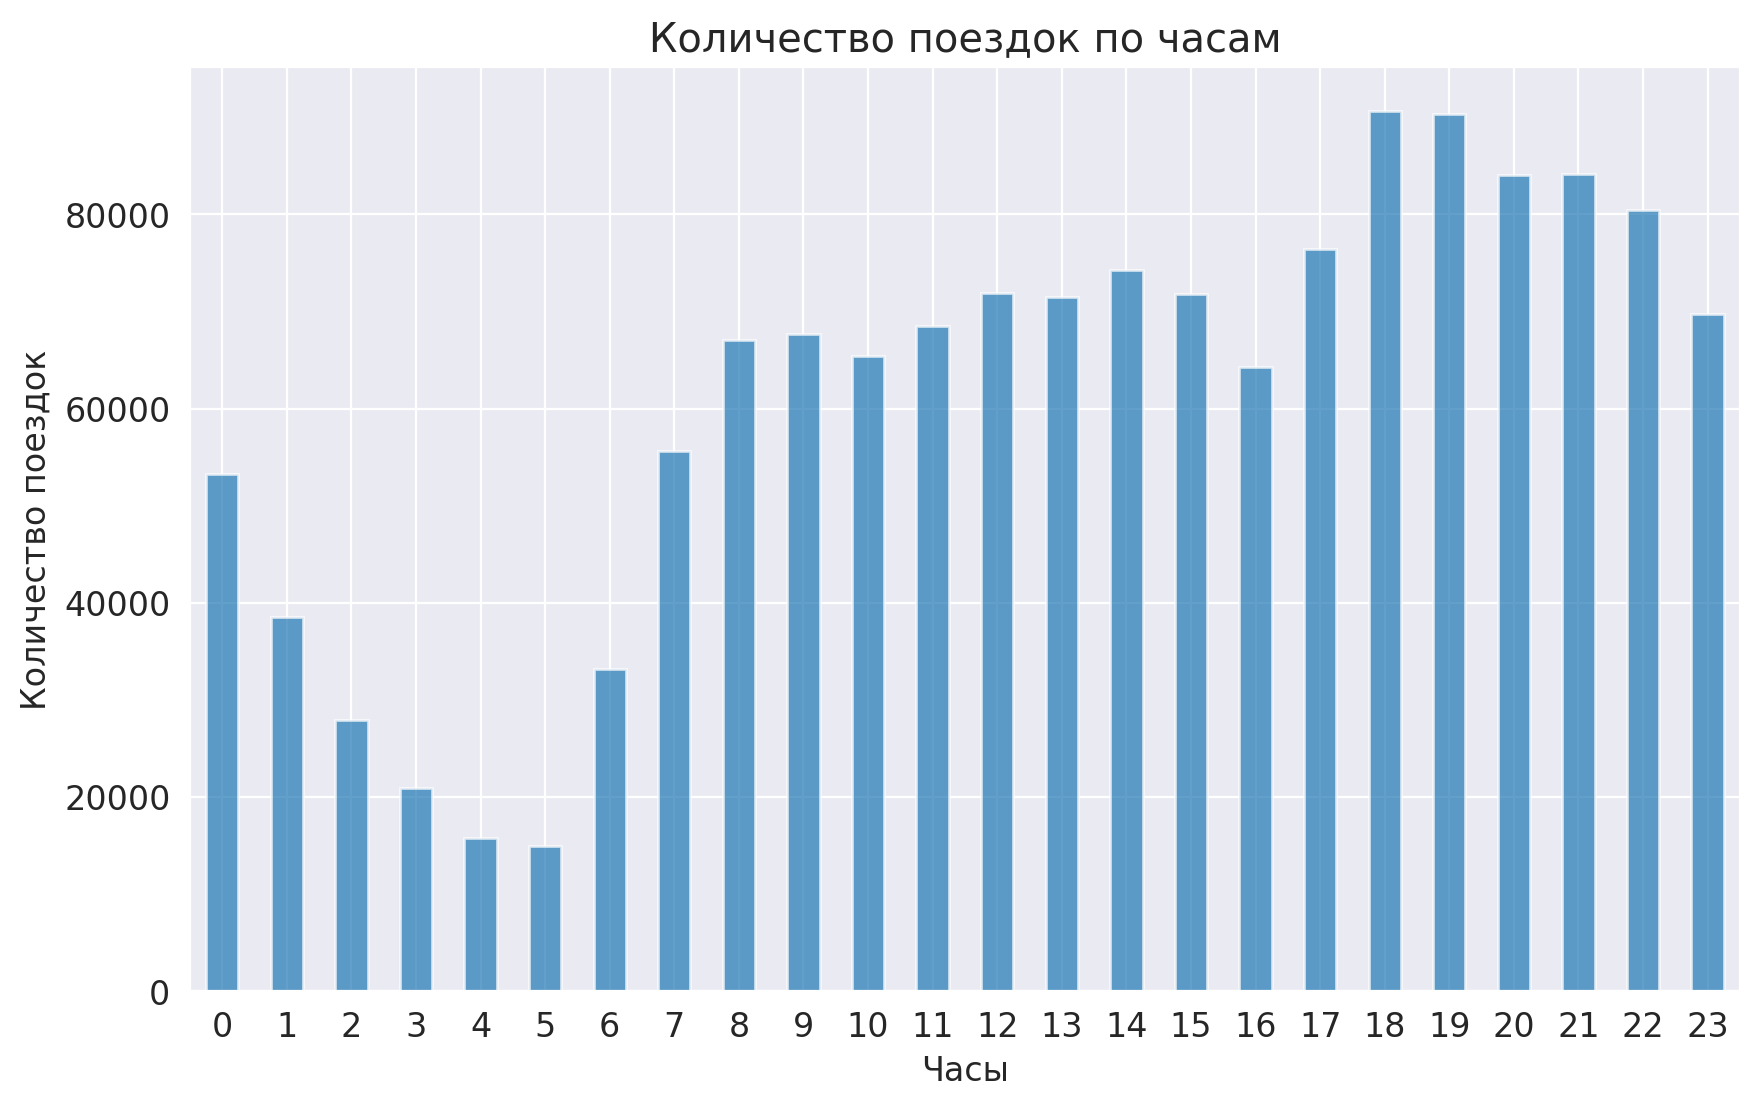

In [122]:
# график поездок по часам
train_df['hour'] = train_df['pickup_datetime'].dt.hour
trips_by_hour = train_df.groupby('hour')['num_trips'].sum()

plt.figure(figsize=(10, 6))
trips_by_hour.plot(kind="bar", alpha=0.7)
plt.title('Количество поездок по часам')
plt.xlabel('Часы')
plt.ylabel('Количество поездок')
plt.xticks(rotation=0)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

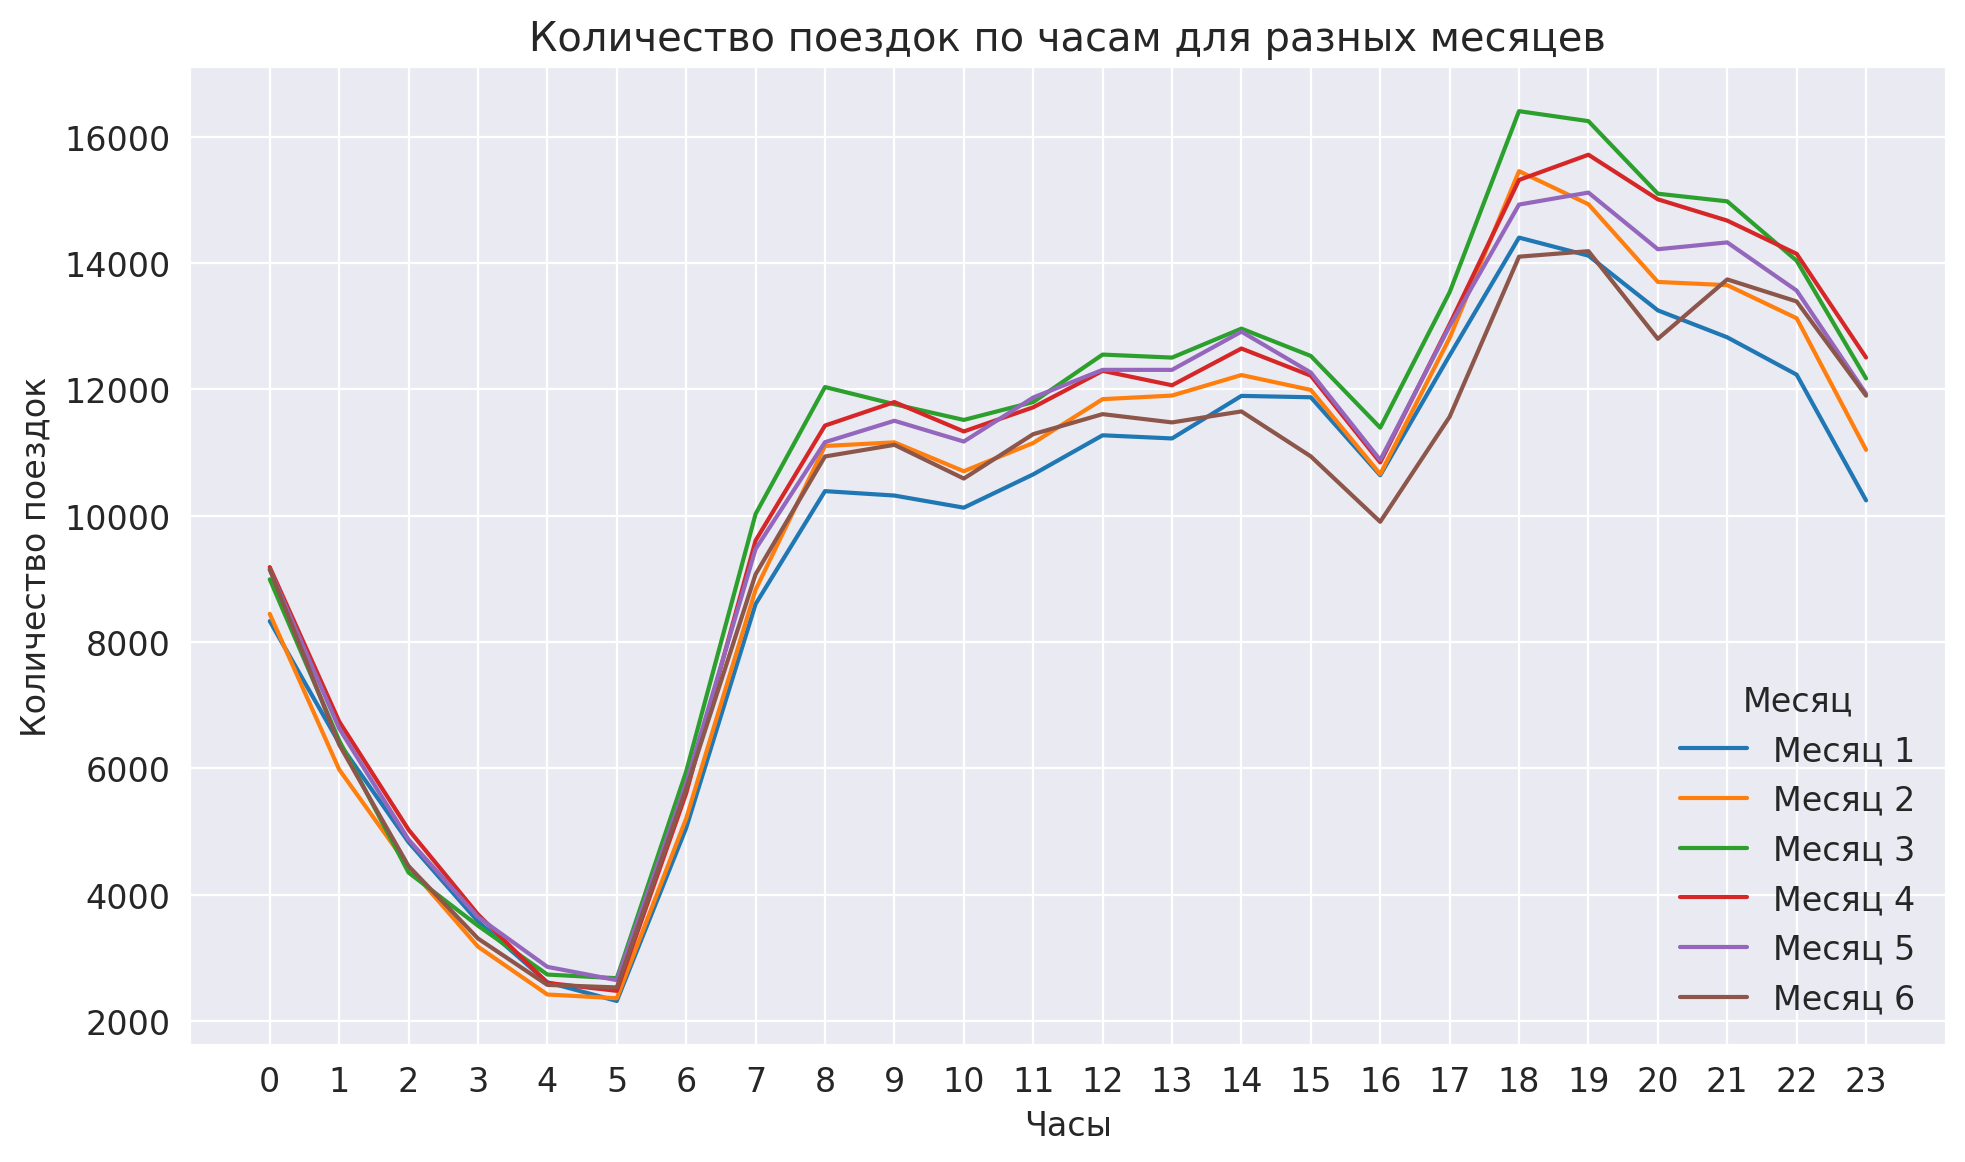

In [123]:
# график зависимости количества поездок от часа в сутках и месяца
train_df['month'] = train_df['pickup_datetime'].dt.month
trips_by_month = train_df.groupby(['month', 'hour'])['num_trips'].sum().unstack()

plt.figure(figsize=(10, 6))
for month in list(trips_by_month.index):
    plt.plot(list(trips_by_month.columns), trips_by_month.loc[month], label=f'Месяц {month}')

plt.title('Количество поездок по часам для разных месяцев')
plt.xlabel('Часы')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title="Месяц", frameon = False, loc="lower right")
plt.tight_layout()

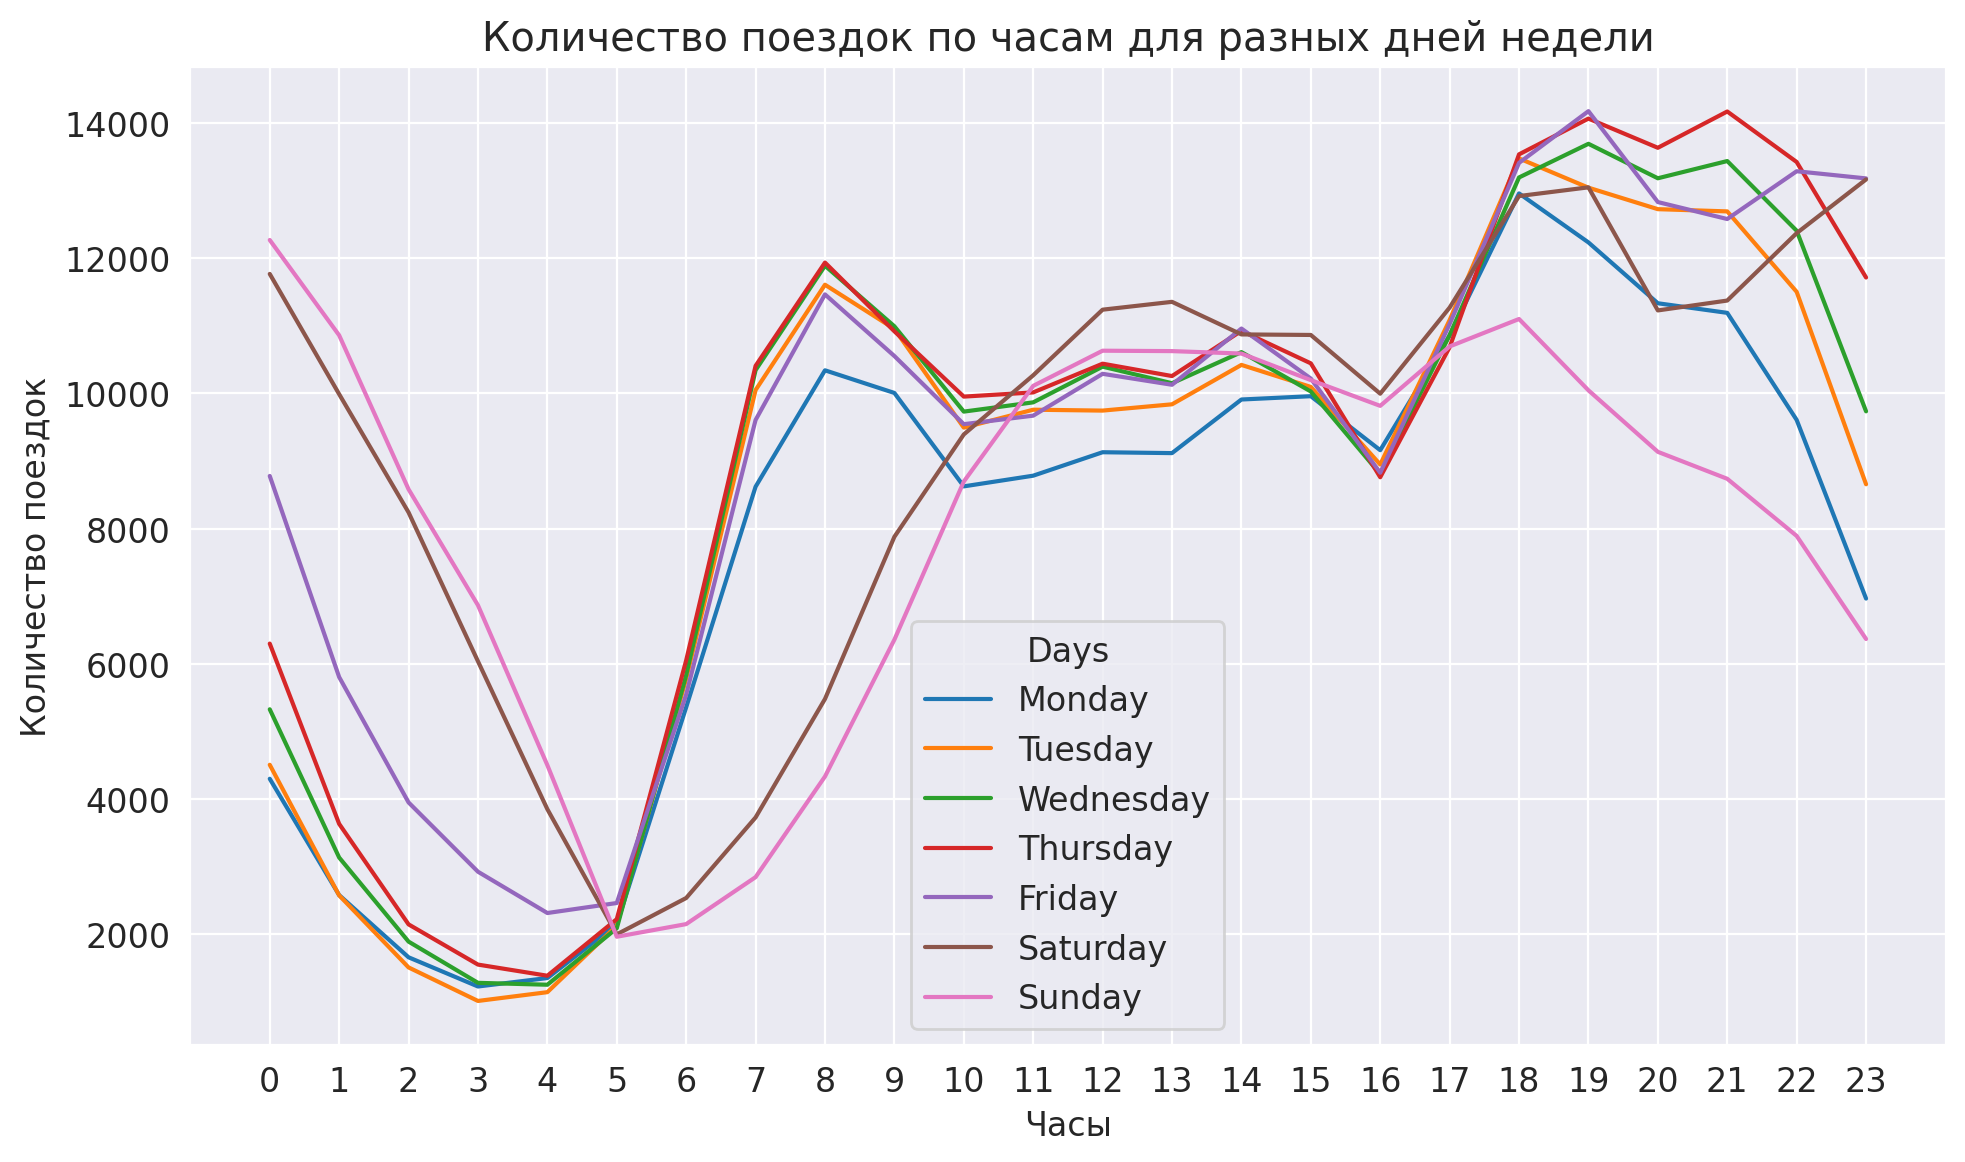

In [124]:
# график зависимости количества поездок от часа в сутках и дня недели
trips_by_day_and_hour = train_df.groupby(['day_of_week', 'hour'])['num_trips'].sum().unstack()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
for day in days:
    plt.plot(list(trips_by_day_and_hour.columns), trips_by_day_and_hour.loc[day], label=f'{day}')

plt.title('Количество поездок по часам для разных дней недели')
plt.xlabel('Часы')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title="Days", loc="best")
plt.tight_layout()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Нетрудно заметить, что количество поездок в некоторые периоды отличается от других:

1) Количество поездок в марте в среднем немного выше, чем в другие месяцы. Это может быть связано с большим количеством влаги и осадков, которые выпадают в это время.

2) Количество поездок в выходные дни выше, чем в будни, в ночной период с 0 до 5 часов. Часть людей возвращаются с вечерних мероприятий в это время в выходные.

3) Количество поездок в выходные дни ниже, чем в будни, в утренний период с 5 до 10 часов. Люди чаще заказывают такси в утренние часы в будние дни, так как исользуют его для поездки на работу.

4) В 16 часов в каждый из дней идет спад относительно числа поездок за предыдущий час, а затем, к 18 часам, происходит резкий подъем, так как рабочий день часто заканчивается в 6 вечера.





**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
# Для построения зависимости log_trip_duration от номера дня в году введем новый признак
train_df['num_day_in_the_year'] = train_df["pickup_datetime"].apply(lambda x: x.dayofyear)

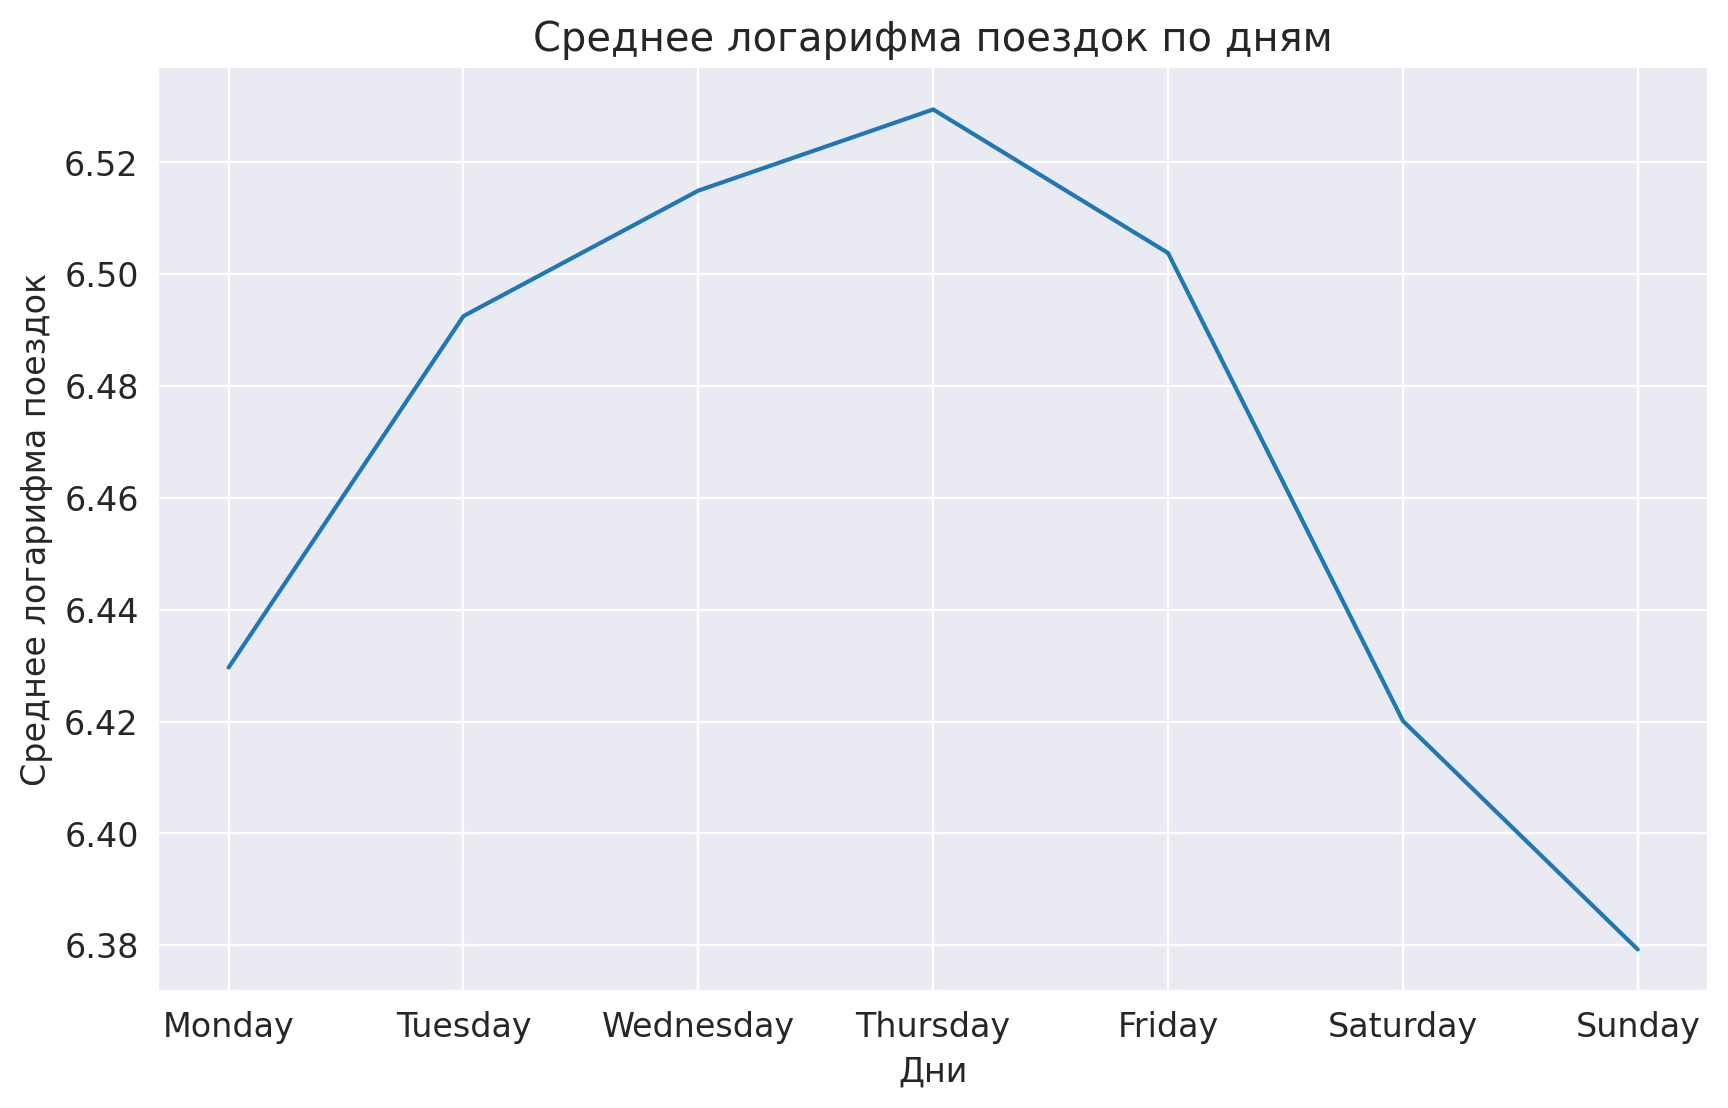

In [127]:
x_train, x_valid = train_test_split(train_df, test_size=0.3)

logmean_by_day = x_train.groupby('day_of_week')['log_trip_duration'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
plt.plot(list(logmean_by_day.index),logmean_by_day.values )
plt.title('Среднее логарифма поездок по дням')
plt.xlabel('Дни')
plt.ylabel('Среднее логарифма поездок')
plt.xticks(rotation=0)
plt.show()

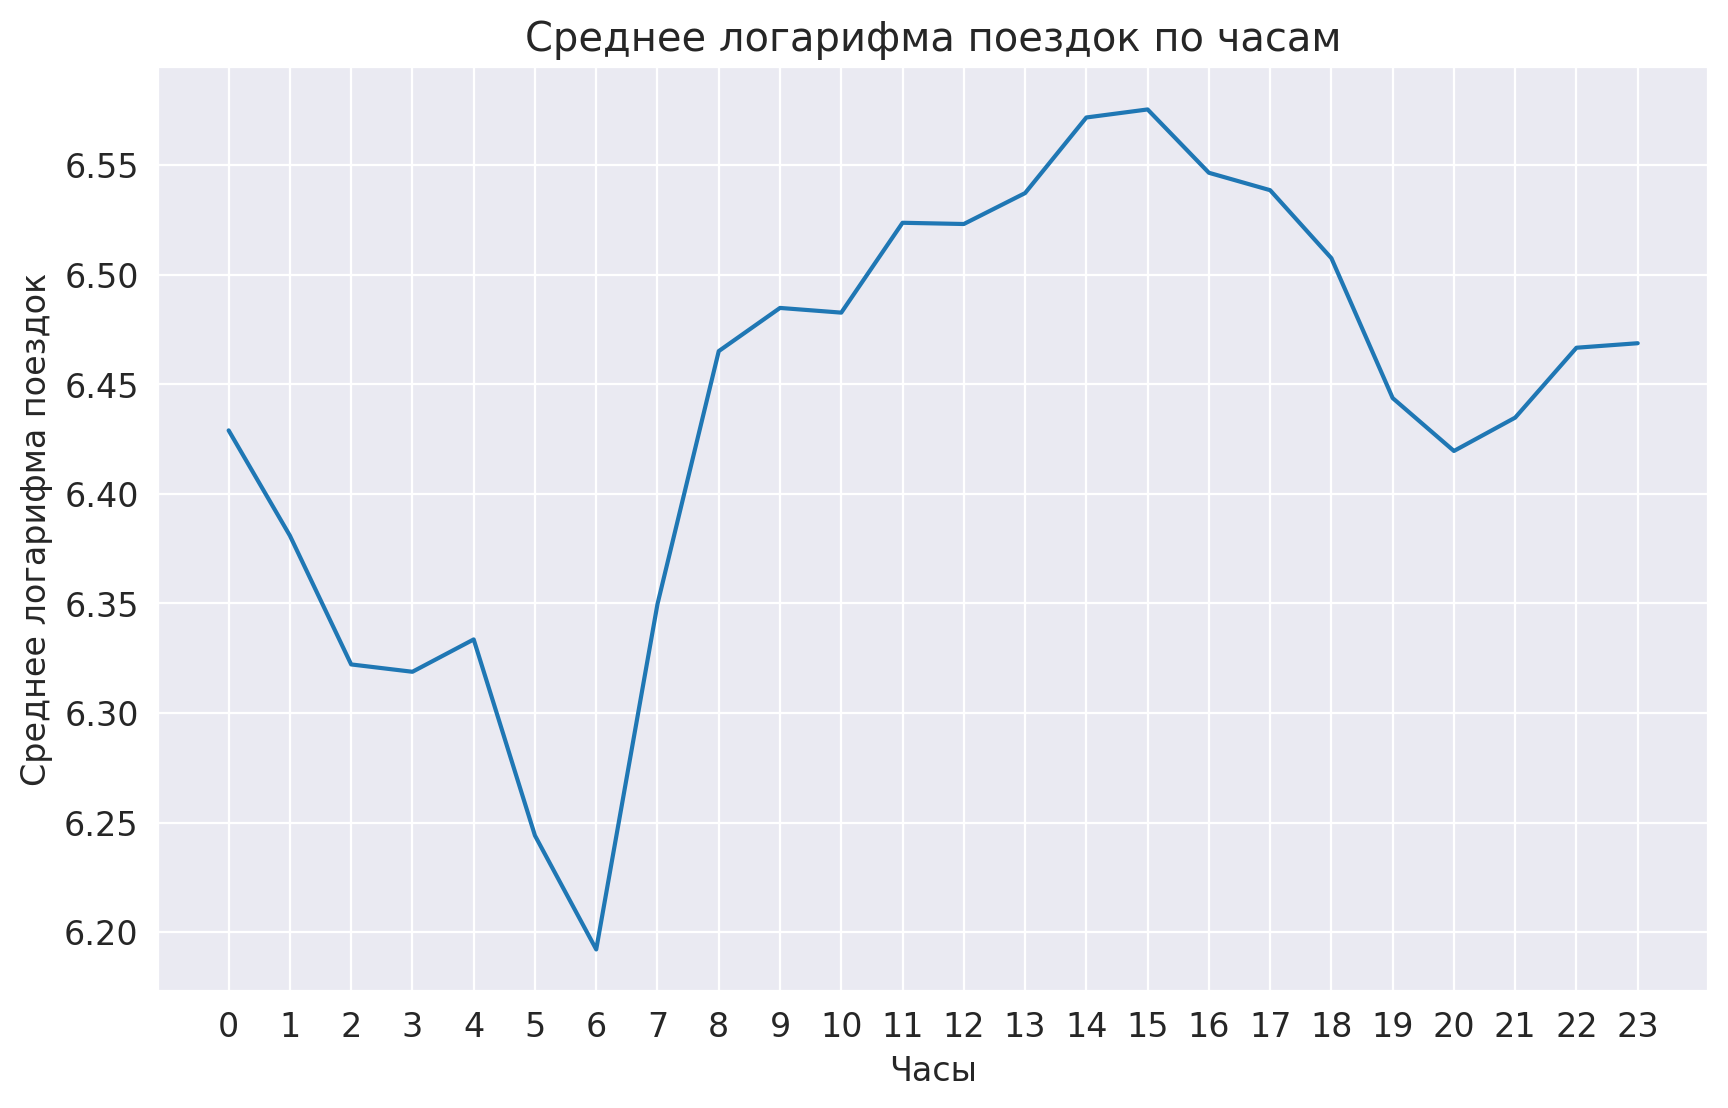

In [128]:
logmean_by_hour = x_train.groupby('hour')['log_trip_duration'].mean()

plt.figure(figsize=(10, 6))
plt.plot(list(logmean_by_hour.index),logmean_by_hour.values)
plt.title('Среднее логарифма поездок по часам')
plt.xlabel('Часы')
plt.ylabel('Среднее логарифма поездок')
plt.xticks(range(0, 24),rotation=0)
plt.show()

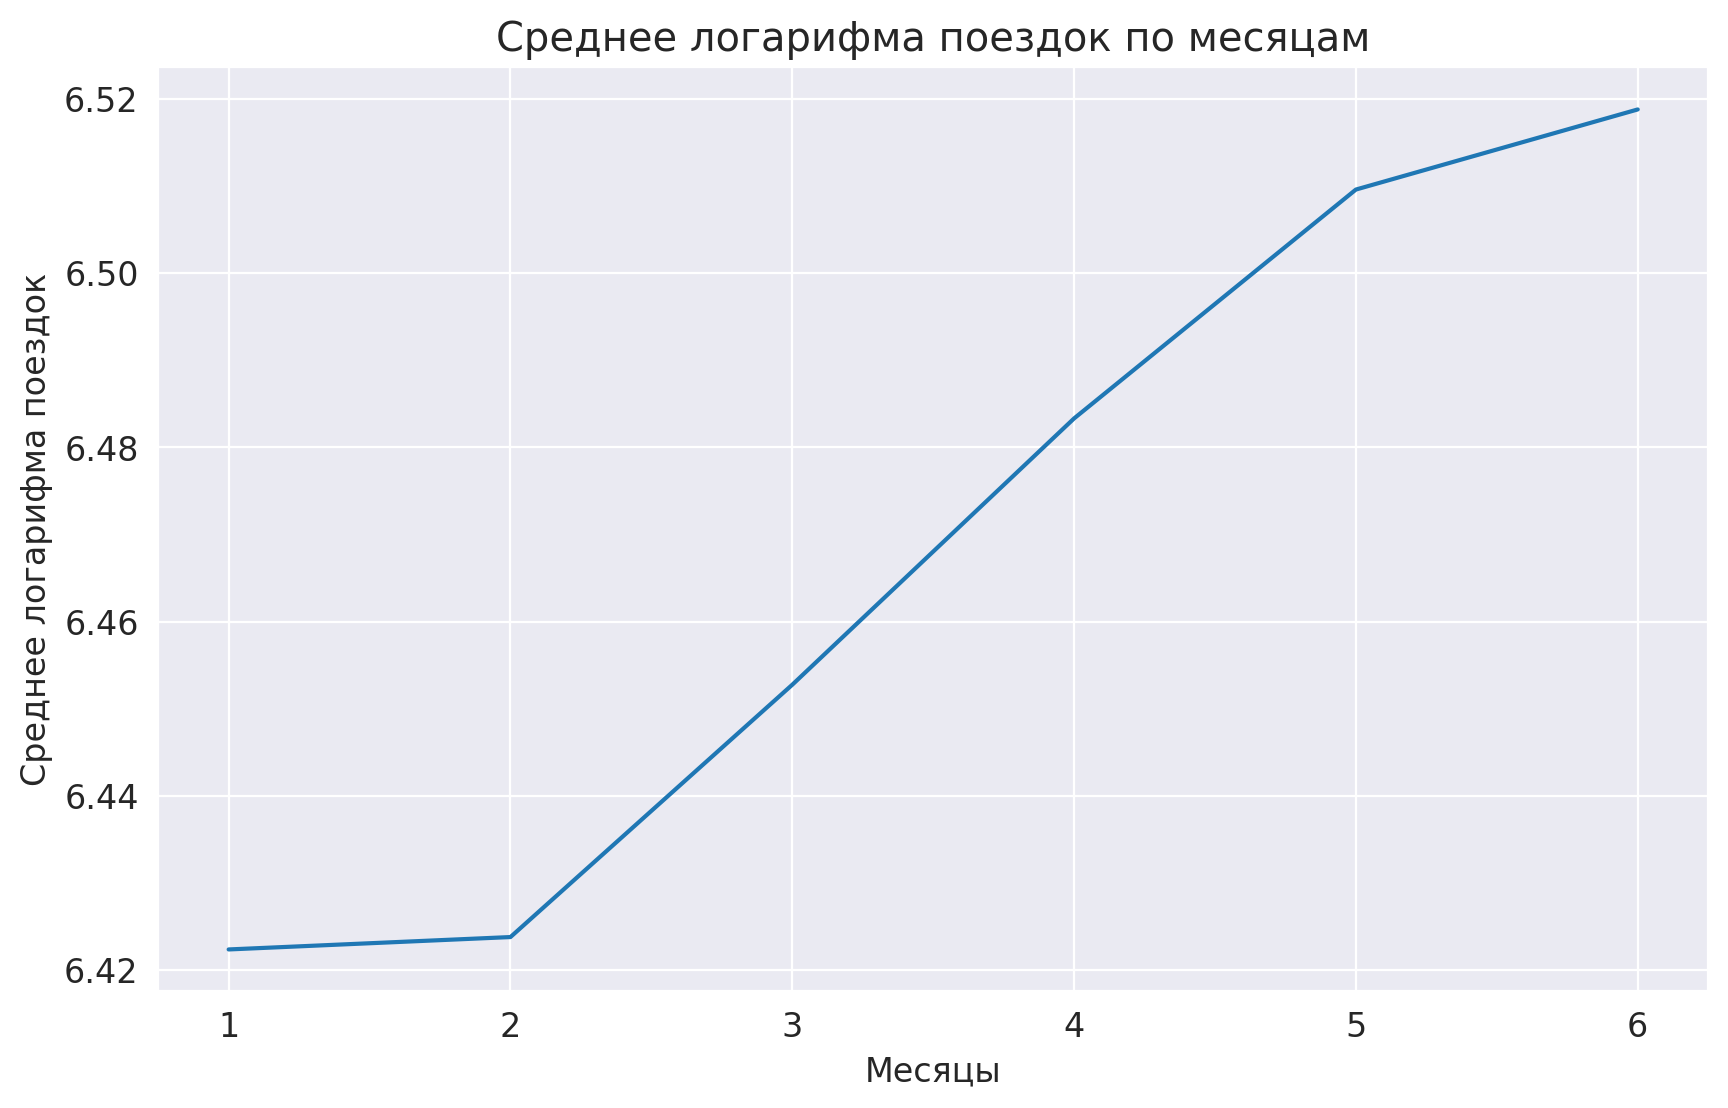

In [129]:
logmean_by_month = x_train.groupby('month')['log_trip_duration'].mean()

plt.figure(figsize=(10, 6))
plt.plot(list(logmean_by_month.index),logmean_by_month.values)
plt.title('Среднее логарифма поездок по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Среднее логарифма поездок')
plt.xticks(rotation=0)
plt.show()

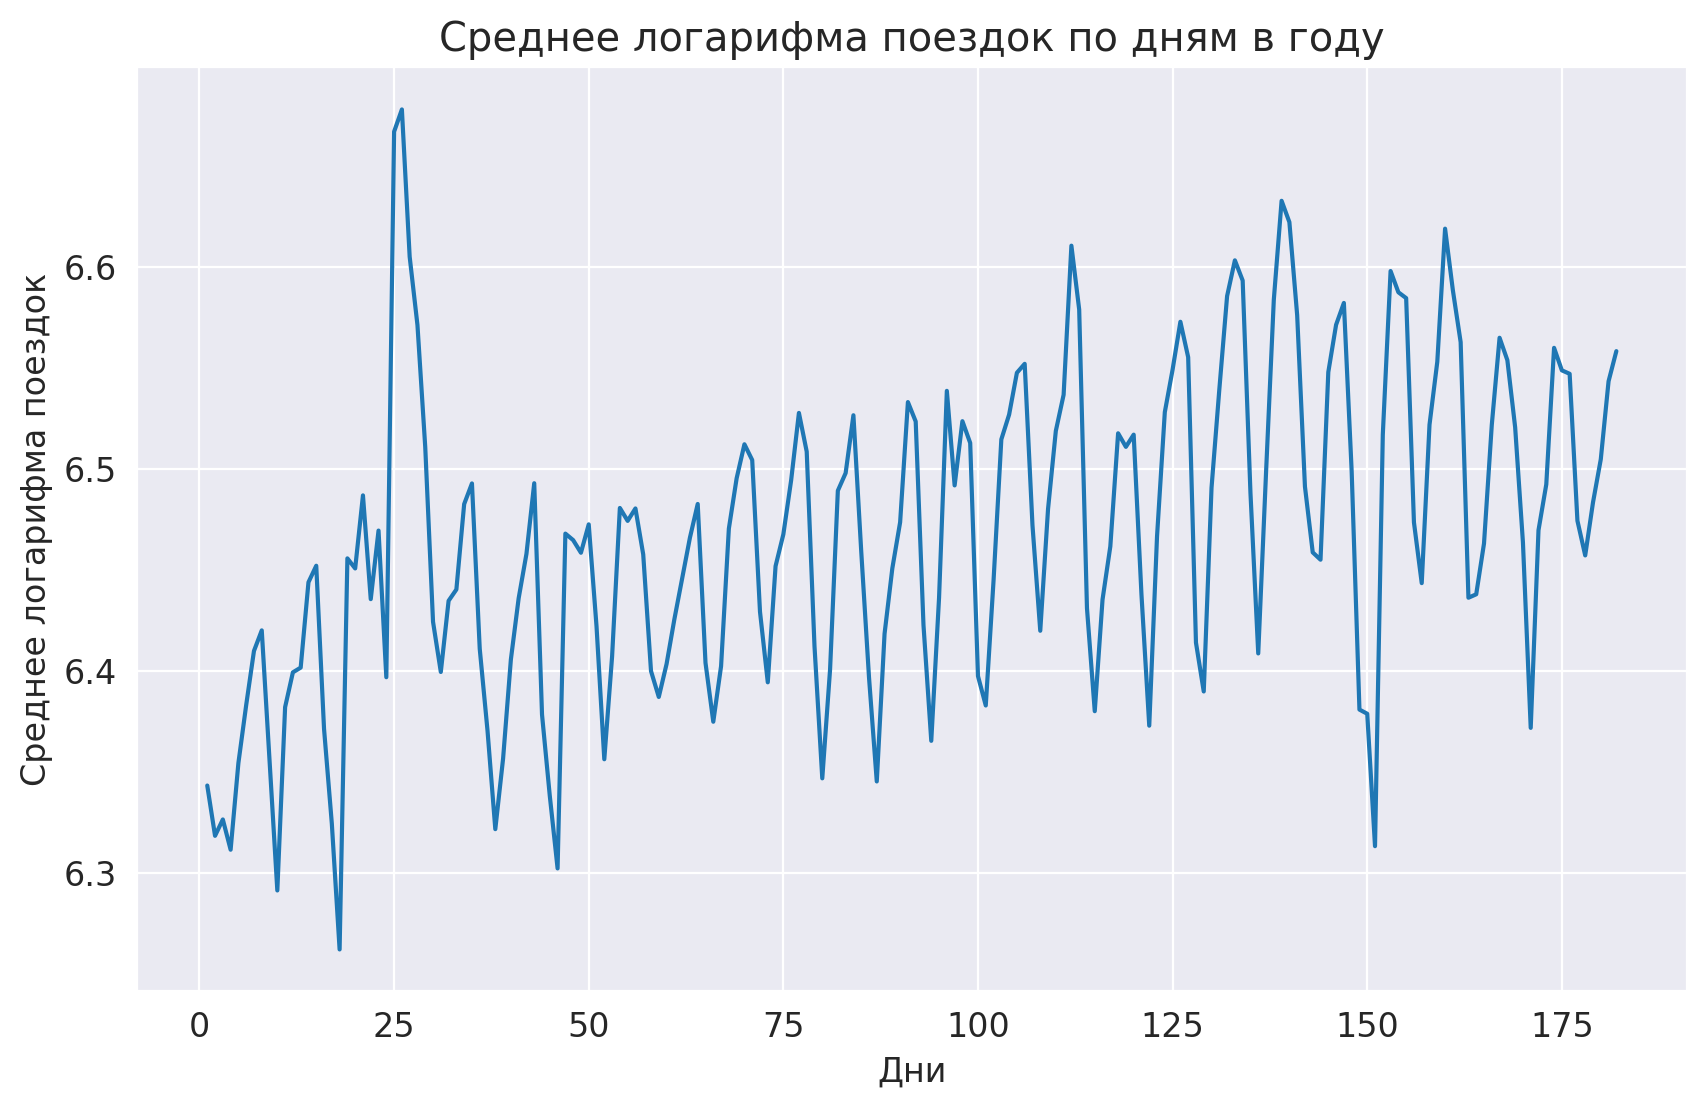

In [130]:
logmean_by_month = x_train.groupby('num_day_in_the_year')['log_trip_duration'].mean()

plt.figure(figsize=(10, 6))
plt.plot(list(logmean_by_month.index),logmean_by_month.values)
plt.title('Среднее логарифма поездок по дням в году')
plt.xlabel('Дни')
plt.ylabel('Среднее логарифма поездок')
plt.xticks(rotation=0)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики зависимости таргета и числа поездок очень похожи друг на друга. Чем больше совершается поездок на такси, тем большие пробки на дорогах, следовательно, тем больше время поездок.

23-24 января поездки занимали гораздо больше времени по сравнению с поездками в выходные. В течении нескольких дней после этого периода дороги были заснежены, что затрудняло движение. 30 мая поездки занимали гораздо меньше времени по сравнению с другими понедельниками. Это связано с опасениями людей относительно нападений в Манхэттене.

log_trip_duration постоянно колеблется в течение года. Это может быть связано со сменой дней недели и загруженности на дорогах.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [131]:
train_df['is_anomaly'] = 0
# в качестве аномальных дней считаем дни, где количество поездок было меньше 6000
train_df['is_anomaly'] = ((train_df['num_day_in_the_year'] == 23) | (train_df['num_day_in_the_year'] == 24) | (train_df['num_day_in_the_year'] == 151)).astype(int)
train_df.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  log_trip_duration  num_trips day_of_week  \
0                  N            455           6.124683          1      Monday   
1                  N            663           6.499787          1      Sunday   
2                  N           2124           7.661998          1     Tuesday   
3                  N            429           6.066108          1   Wednesday   
4                  N            435           6.079933          1    Saturday   

   hour  month  num_day_in_the_year  is_anomaly  
0    17      3                   74           0  
1     0      6                  164           0  
2    11      1                   19           0  
3    19      4                   97           0  
4    13      3                   86           0

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

В качетве категориальных признаков стоит рассматривать день недели, месяц, час, наличие аномалии и день в году, так как каждый из них отвечает за отнесение значения признака к определенной группе.


**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [132]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [133]:
category_features = ['day_of_week', 'hour', 'month', 'is_anomaly', 'num_day_in_the_year']
numerical_features = []

train_df_essential = train_df[category_features + numerical_features + ['log_trip_duration'] + ['trip_duration']].copy()
y = train_df_essential['log_trip_duration'].apply(lambda x: x if x > 1e-9 else 0)

x_train, x_valid, y_train, y_valid = train_test_split(train_df_essential, y, test_size=0.3)

prep = ColumnTransformer(transformers = [
    ('categorial', OneHotEncoder(), category_features),
    ('numerical', StandardScaler(), numerical_features)
])

model = Pipeline([
    ('prep', prep),
    ('regressor', Ridge())
])

model.fit(x_train, y_train)

y_pred = model.predict(x_valid)
rmsle_value = rmsle(y_valid, y_pred)
print(f'RMSLE = {rmsle_value}')


RMSLE = 0.7841251110175611


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [134]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [135]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df, y, test_size=0.3)


In [136]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
your_lat_values = x_train['pickup_latitude'].sample(1000)
your_lon_values = x_train['pickup_longitude'].sample(1000)

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Судя по карте данные скопления точек вызваны наличием аэропортов вблизи этих регионов. Так как аэропорты зачастую расположены в отдалении от спальных районов, они образуют отдельный класс точек.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [137]:
train_df_essential['haversine'] = train_df.apply(lambda x: haversine((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude']), unit=Unit.METERS), axis=1)
train_df_essential.head()

day_of_week  hour  month  is_anomaly  num_day_in_the_year  \
0      Monday    17      3           0                   74   
1      Sunday     0      6           0                  164   
2     Tuesday    11      1           0                   19   
3   Wednesday    19      4           0                   97   
4    Saturday    13      3           0                   86   

   log_trip_duration  trip_duration    haversine  
0           6.124683            455  1498.522849  
1           6.499787            663  1805.509663  
2           7.661998           2124  6385.107315  
3           6.066108            429  1485.500475  
4           6.079933            435  1188.590101

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [138]:
train_df_essential['log_haversine'] = train_df_essential['haversine'].apply(lambda x: np.log(x) if x > 1e-9 else np.nan)
train_df_essential.head()

day_of_week  hour  month  is_anomaly  num_day_in_the_year  \
0      Monday    17      3           0                   74   
1      Sunday     0      6           0                  164   
2     Tuesday    11      1           0                   19   
3   Wednesday    19      4           0                   97   
4    Saturday    13      3           0                   86   

   log_trip_duration  trip_duration    haversine  log_haversine  
0           6.124683            455  1498.522849       7.312235  
1           6.499787            663  1805.509663       7.498598  
2           7.661998           2124  6385.107315       8.761724  
3           6.066108            429  1485.500475       7.303507  
4           6.079933            435  1188.590101       7.080523

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [139]:
# train_df = pd.merge(train_df, train_df_original[['id', 'trip_duration']], on='id', how='inner')
# train_df

In [140]:
train_df_essential['log_haversine'].isnull().sum()

5897

In [141]:
corr_haversine_y = train_df_essential['log_trip_duration'].corr(train_df_essential['haversine'])
corr_log_haversine_y = train_df_essential['log_trip_duration'].corr(train_df_essential['log_haversine'])
print(f'Корреляция расстояния и длительности поездки:{corr_haversine_y}')
print(f'Корреляция расстояния и логарифма длительности поездки:{corr_log_haversine_y}')

Корреляция расстояния и длительности поездки:0.5747978604351106
Корреляция расстояния и логарифма длительности поездки:0.7721164576797239


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

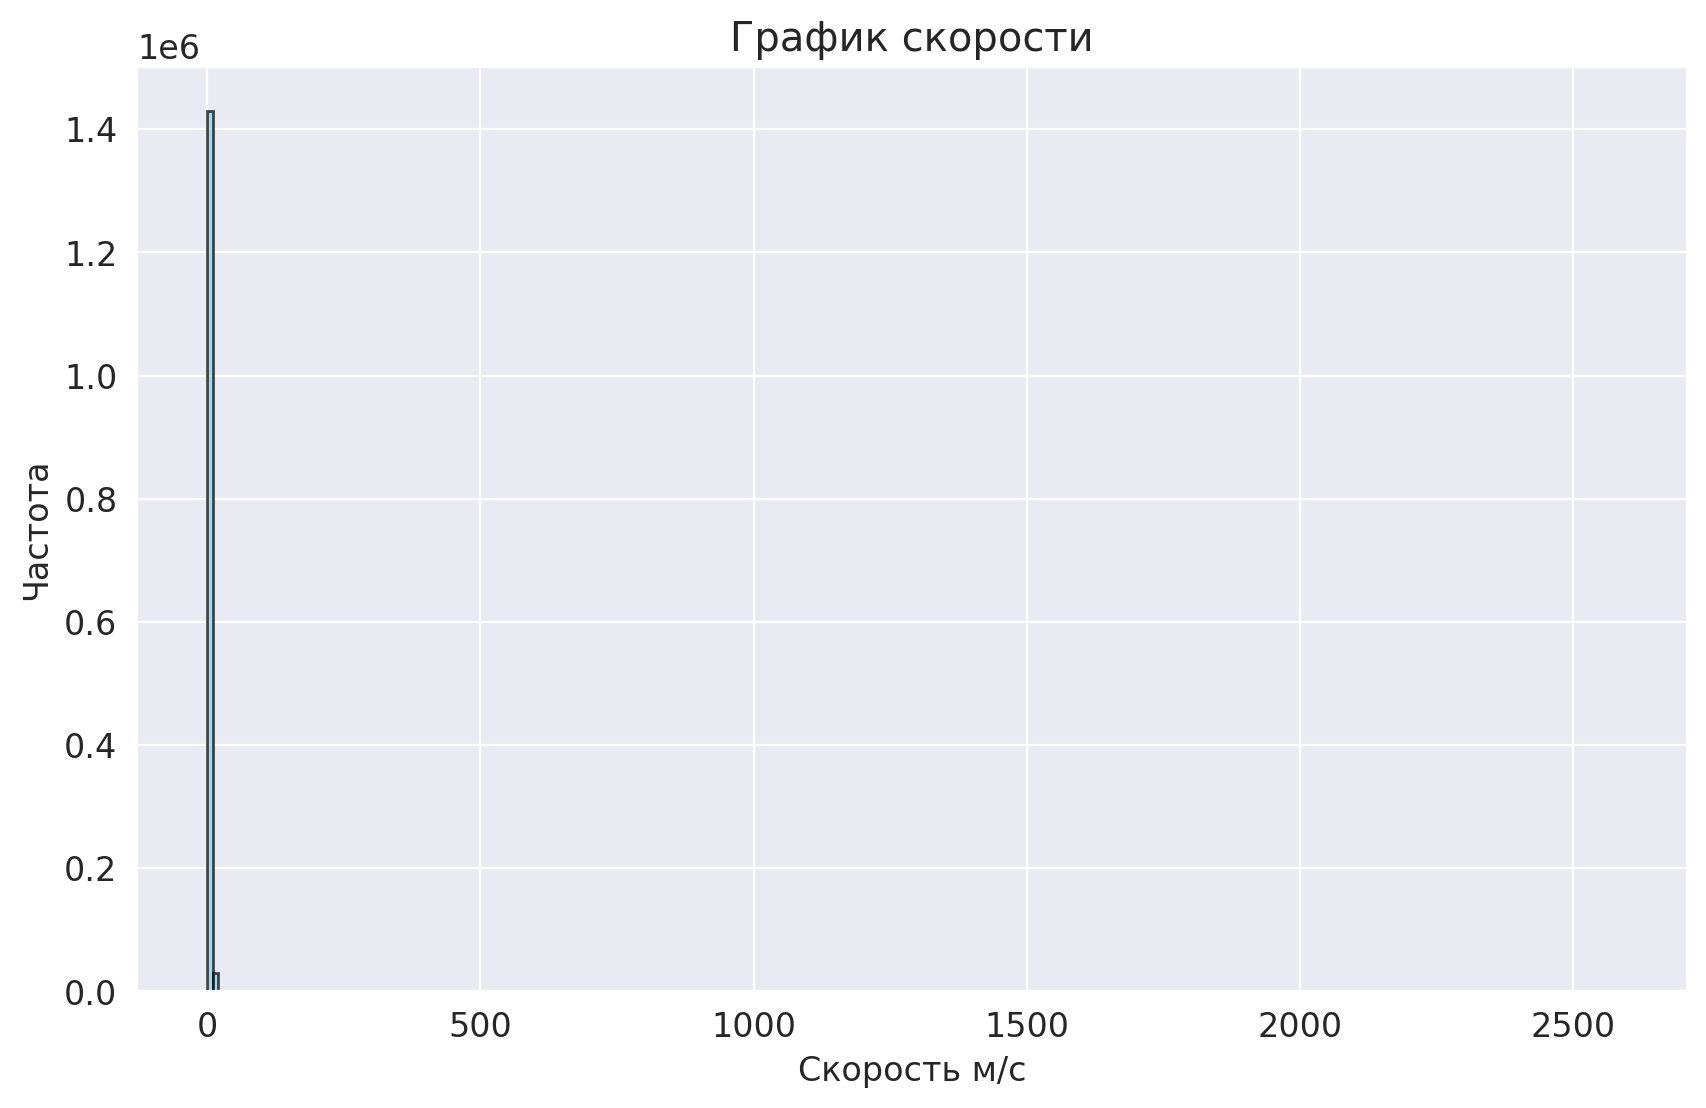

In [142]:
train_df_essential['speed'] = train_df_essential['haversine'] / train_df_essential['trip_duration']
binwidth = 10
plt.figure(figsize=(10, 6))

temp_df = train_df_essential
plt.hist(temp_df["speed"], bins=range(int(min(temp_df["speed"])), int(max(temp_df["speed"])) + binwidth, binwidth), color='skyblue', alpha=0.7, edgecolor='black')
plt.title('График скорости')
plt.xlabel('Скорость м/с')
plt.ylabel('Частота')

plt.show()

In [143]:
train_df_essential['speed'].max()

2576.3470950534875

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

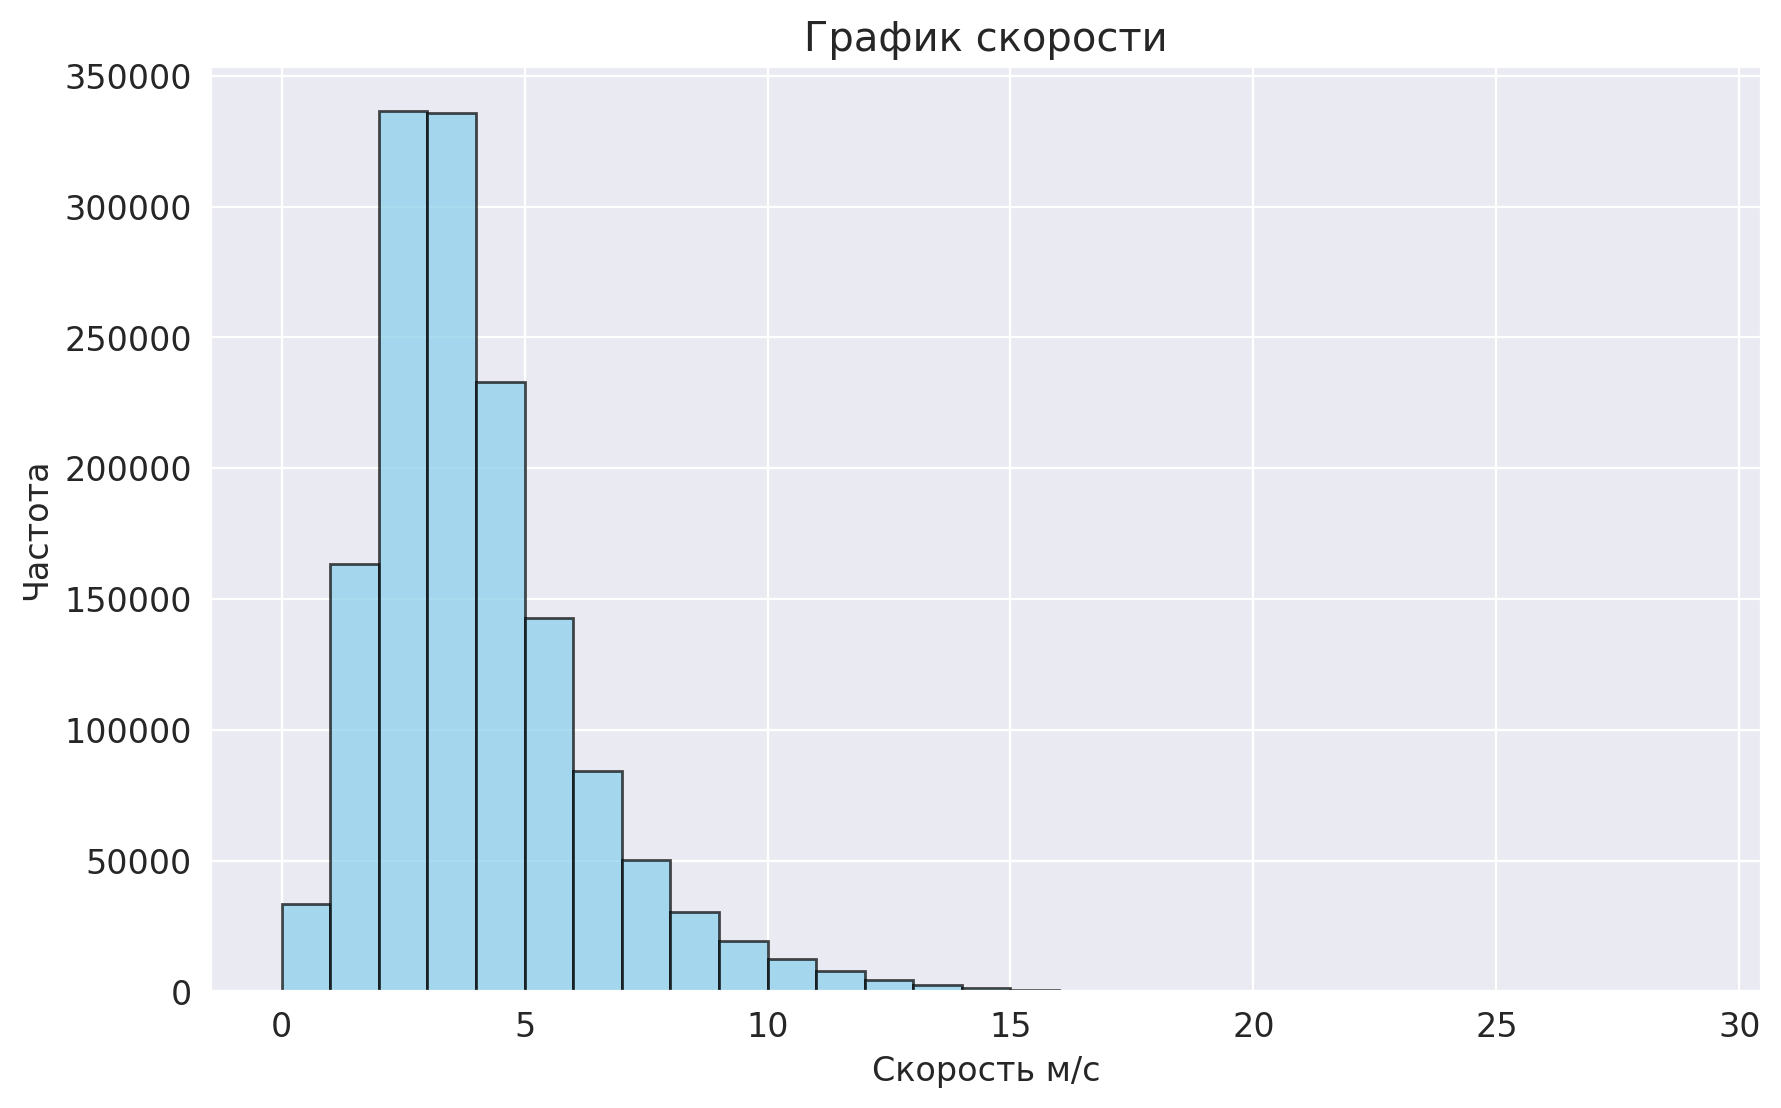

In [144]:
plt.figure(figsize=(10, 6))
binwidth = 1

temp_df = train_df_essential[train_df_essential['speed'] < 30]
plt.hist(temp_df["speed"], bins=range(int(min(temp_df["speed"])), int(max(temp_df["speed"])) + binwidth, binwidth), color='skyblue', alpha=0.7, edgecolor='black')
plt.title('График скорости')
plt.xlabel('Скорость м/с')
plt.ylabel('Частота')

plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

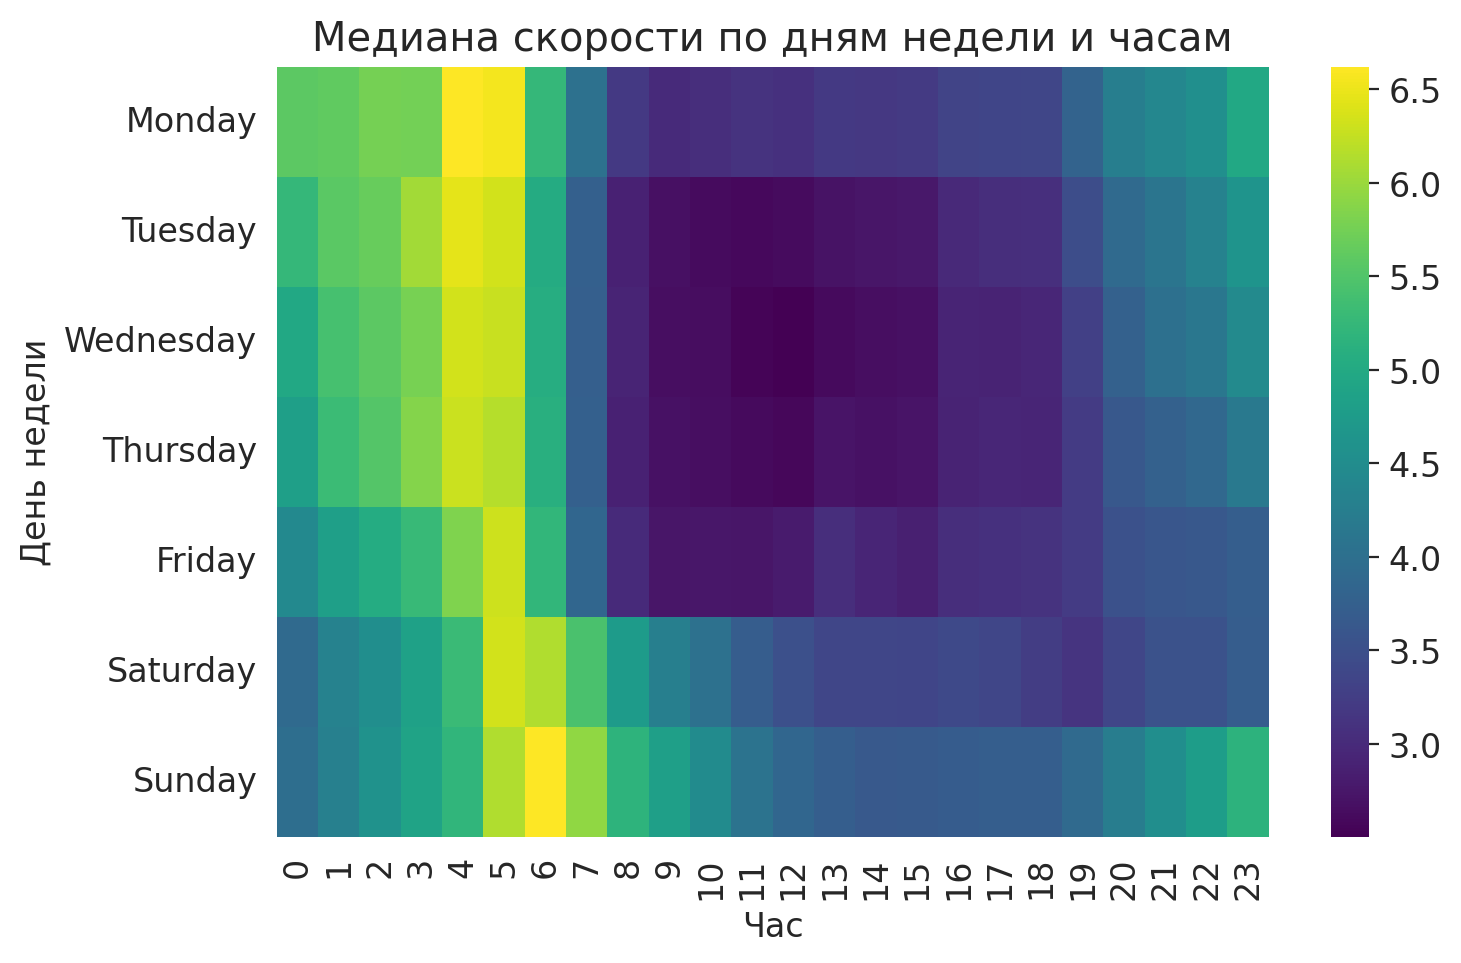

In [145]:
speed_median = train_df_essential.groupby(['day_of_week', 'hour'])['speed'].median()
speed_median = speed_median.unstack().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

sns.heatmap(speed_median, cmap = "viridis")

plt.ylabel('День недели')
plt.xlabel('Час')
plt.title('Медиана скорости по дням недели и часам')

plt.show()


Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Обучение модели с использованием двух линейно зависимых признаков (speed, haversine) приведет к усложнению интерпретации модели, ее усложнениию и неточным прогнозам на новых данных.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

Нетрудно заметить, что скорость максимальна в ранние утренние часы (5-7 утра), и также показывает высокие значения в течение ночи вне зависимости от дня недели. Минимальные значения достигаются в рабочие часы (8-18 часов) в будние дни.

In [146]:
train_df_essential['is_busy'] = ((train_df_essential['hour'] >= 8) & (train_df_essential['hour'] <= 18) & (train_df_essential['day_of_week'] != 'Saturday') & (train_df_essential['day_of_week'] != 'Sunday')).astype(int)
train_df_essential['is_free'] = ((train_df_essential['hour'] < 7) & (train_df_essential['hour'] >= 0)).astype(int)
train_df_essential.head()

day_of_week  hour  month  is_anomaly  num_day_in_the_year  \
0      Monday    17      3           0                   74   
1      Sunday     0      6           0                  164   
2     Tuesday    11      1           0                   19   
3   Wednesday    19      4           0                   97   
4    Saturday    13      3           0                   86   

   log_trip_duration  trip_duration    haversine  log_haversine     speed  \
0           6.124683            455  1498.522849       7.312235  3.293457   
1           6.499787            663  1805.509663       7.498598  2.723242   
2           7.661998           2124  6385.107315       8.761724  3.006171   
3           6.066108            429  1485.500475       7.303507  3.462705   
4           6.079933            435  1188.590101       7.080523  2.732391   

   is_busy  is_free  
0        1        0  
1        0        1  
2        1        0  
3        0        0  
4        0        0

**Для наглядности при выполнении задания 8 нарисуем точки начала и конца поездок на карте:**

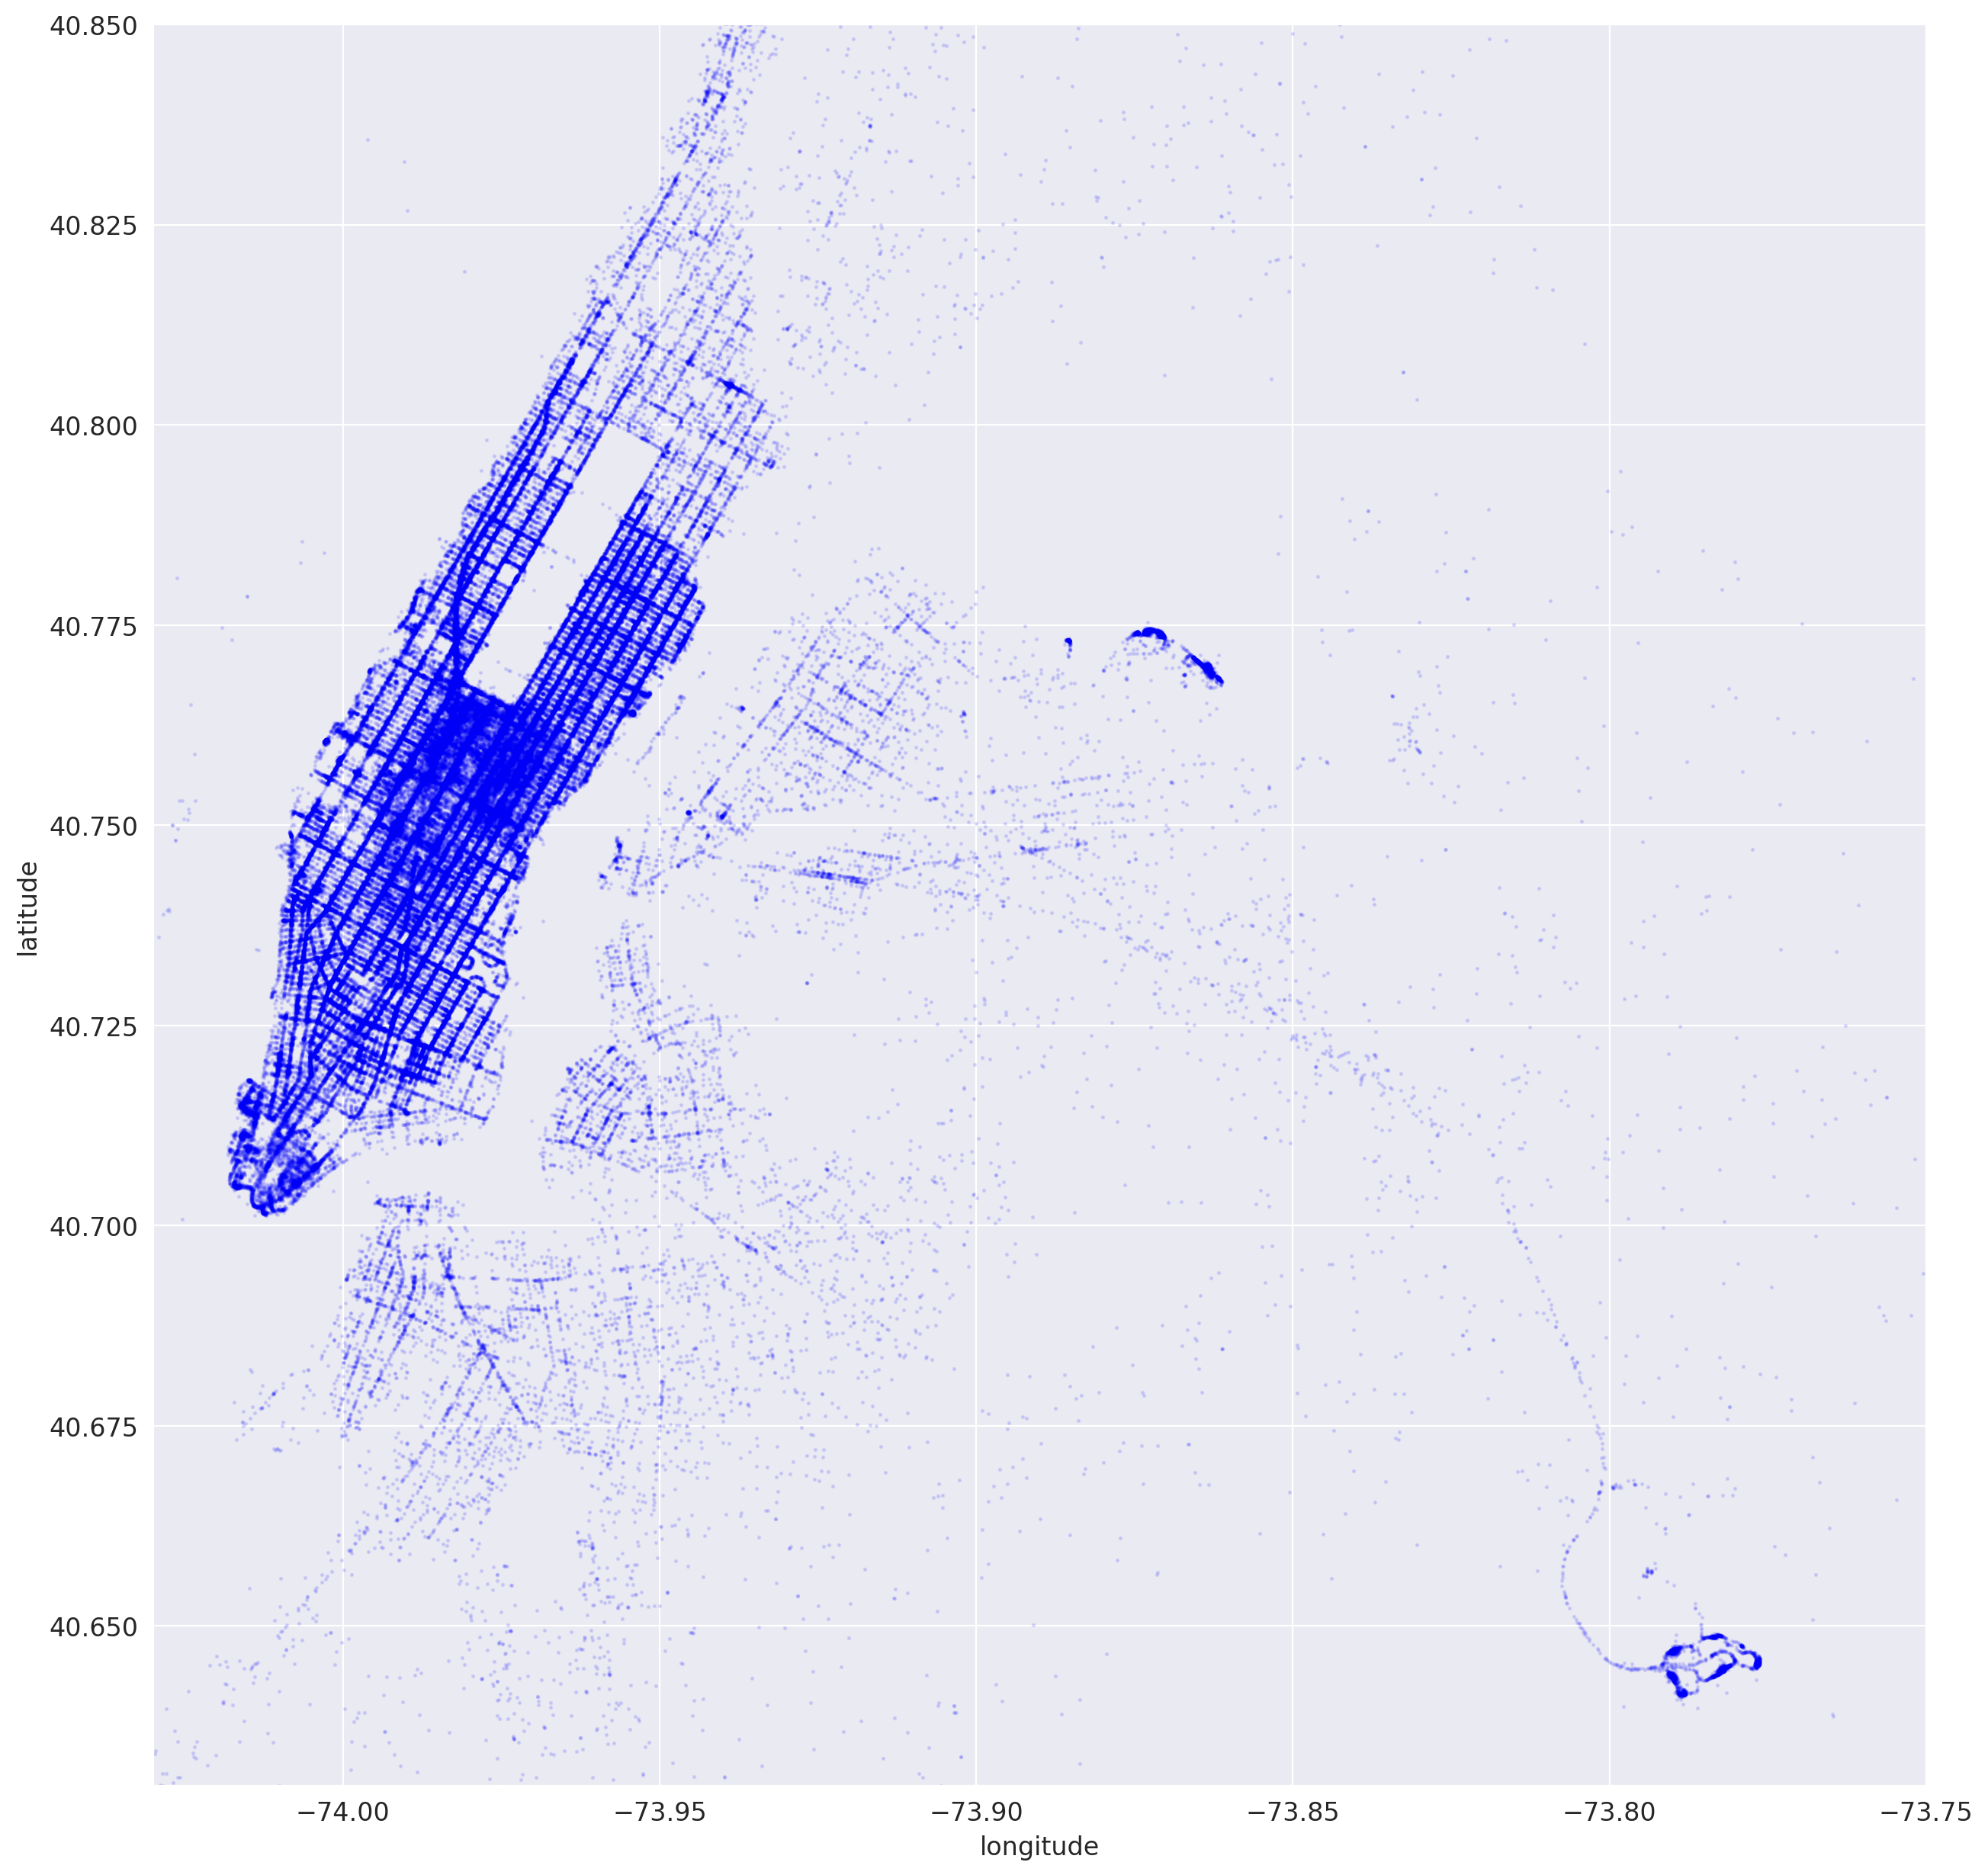

In [147]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(train_df['dropoff_longitude'].values[:N], train_df['dropoff_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.scatter(train_df['pickup_longitude'].values[:N], train_df['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

Так как эти участки удалены от основной области, модель может работать на них по-другому. Учет этих особенностей может помочь повысить точность предсказаний.

In [148]:
# для первого выброса
out1_long_border = (-73.796, -73.774)
out1_lat_border = (40.635, 40.655)

train_df['started_in_outliers_1'] = ((train_df['pickup_longitude'] >= out1_long_border[0]) &
                                     (train_df['pickup_longitude'] <= out1_long_border[1]) &
                                     (train_df['pickup_latitude'] >= out1_lat_border[0]) &
                                     (train_df['pickup_latitude'] <= out1_lat_border[1]))

train_df['ended_in_outliers_1'] = ((train_df['dropoff_longitude'] >= out1_long_border[0]) &
                                   (train_df['dropoff_longitude'] <= out1_long_border[1]) &
                                   (train_df['dropoff_latitude'] >= out1_lat_border[0]) &
                                   (train_df['dropoff_latitude'] <= out1_lat_border[1]))



In [149]:
# для второго выброса
out2_long_border = (-73.89, -73.86)
out2_lat_border = (40.768, 40.775)

train_df['started_in_outliers_2'] = ((train_df['pickup_longitude'] >= out2_long_border[0]) &
                                     (train_df['pickup_longitude'] <= out2_long_border[1]) &
                                     (train_df['pickup_latitude'] >= out2_lat_border[0]) &
                                     (train_df['pickup_latitude'] <= out2_lat_border[1]))

train_df['ended_in_outliers_2'] = ((train_df['dropoff_longitude'] >= out2_long_border[0]) &
                                   (train_df['dropoff_longitude'] <= out2_long_border[1]) &
                                   (train_df['dropoff_latitude'] >= out2_lat_border[0]) &
                                   (train_df['dropoff_latitude'] <= out2_lat_border[1]))



**Основная область поездок:**

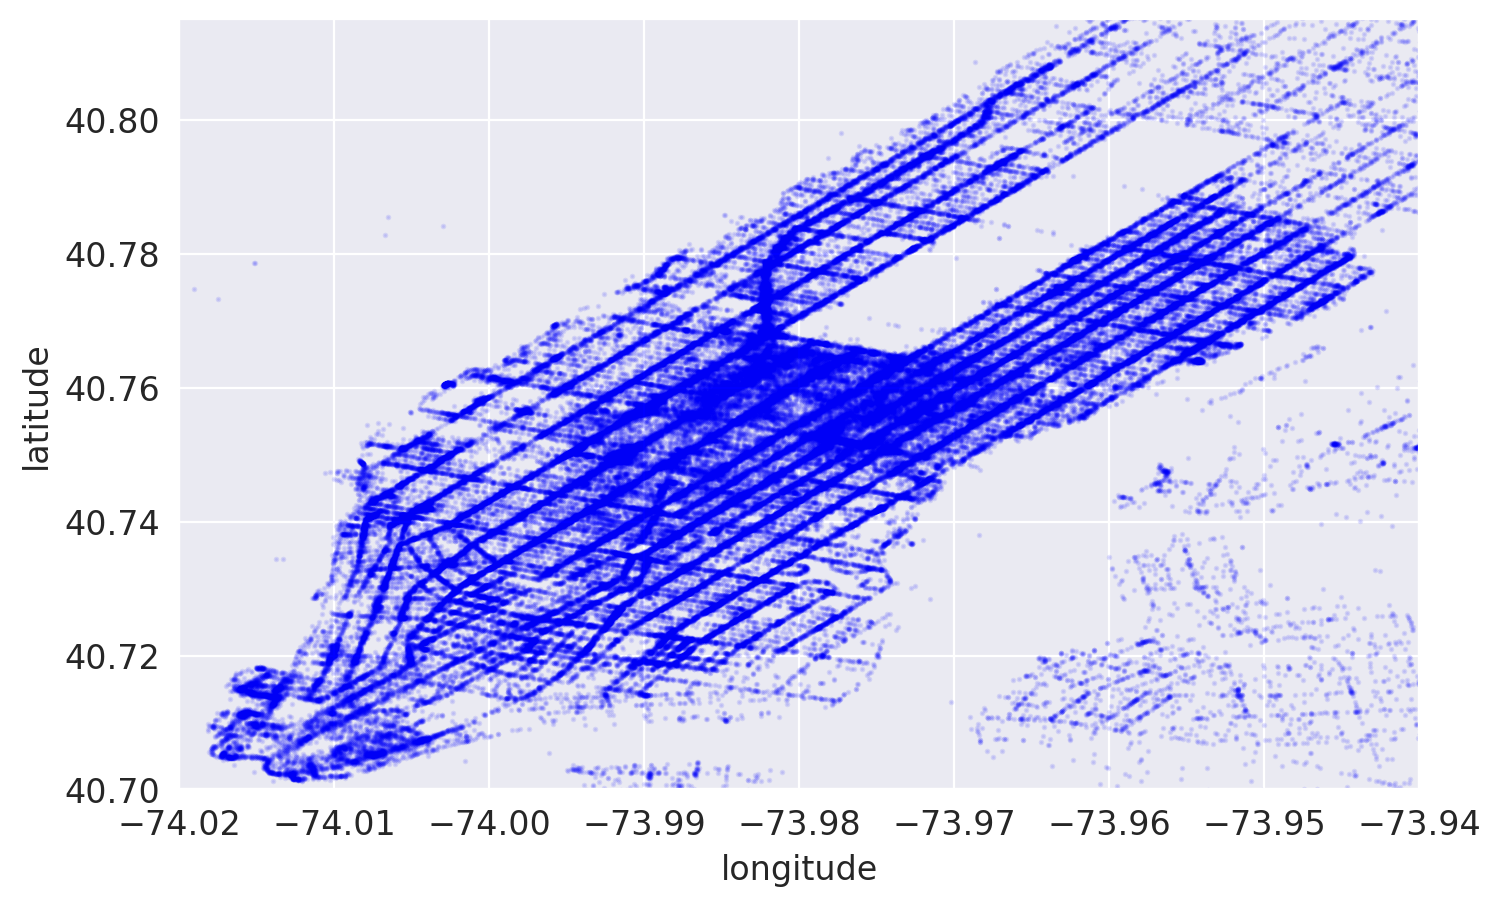

In [150]:
main_long_border = (-74.02, -73.94)
main_lat_border = (40.7, 40.815)

N=100000

plt.scatter(train_df['dropoff_longitude'].values[:N], train_df['dropoff_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.scatter(train_df['pickup_longitude'].values[:N], train_df['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(main_lat_border)
plt.xlim(main_long_border)
plt.show()


**Область вблизи аэропорта 2:**

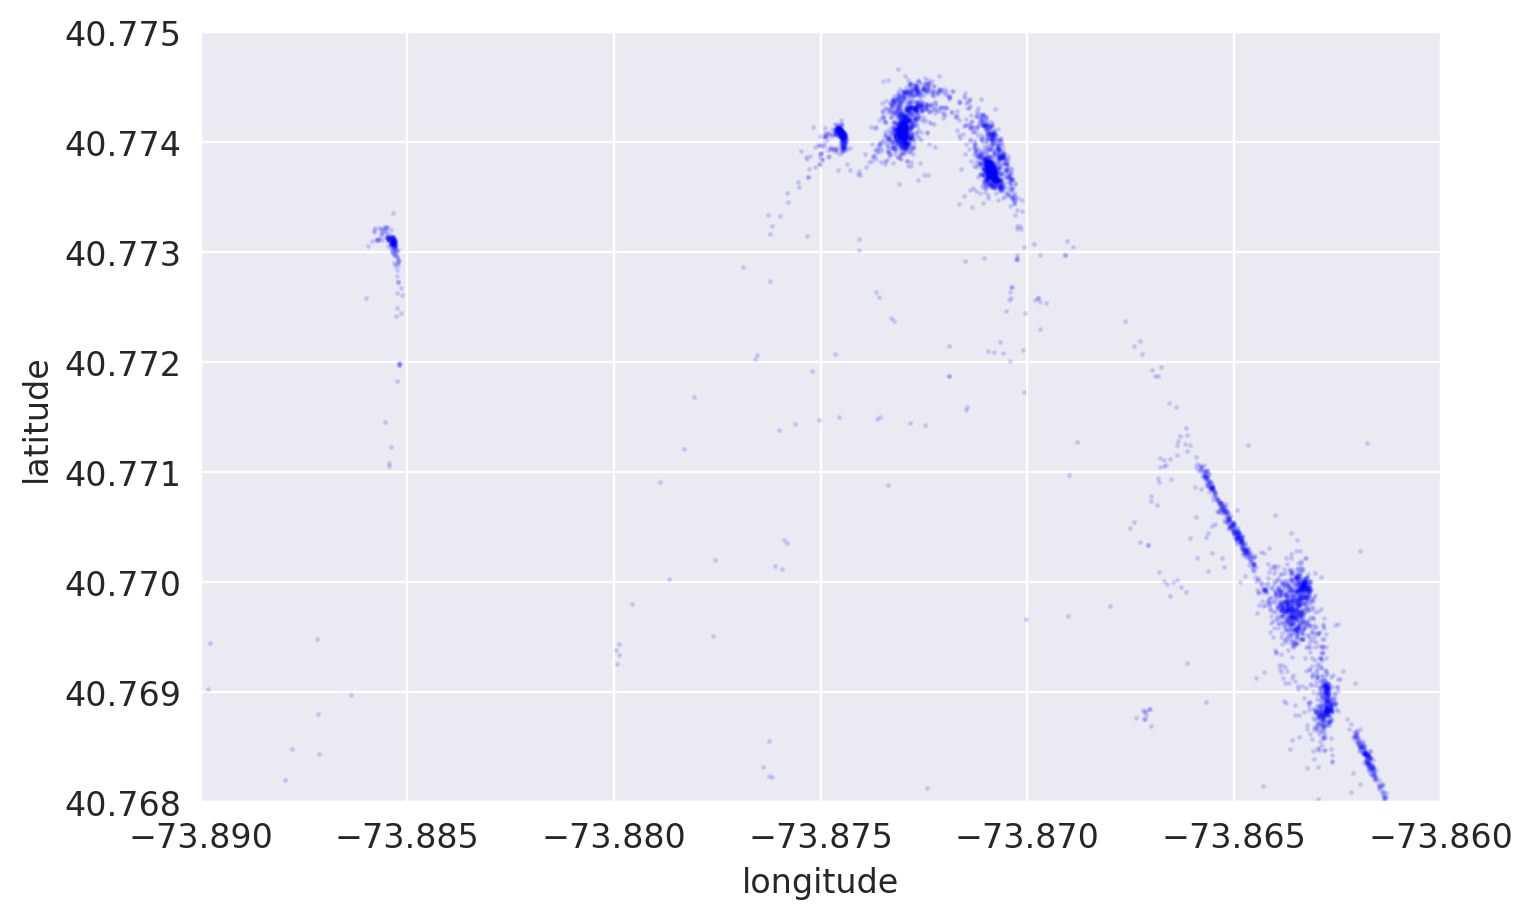

In [151]:
main_long_border = (-74, -73.95)
main_lat_border = (40.7, 40.815)

N=100000
out2_long_border = (-73.89, -73.86)
out2_lat_border = (40.768, 40.775)

plt.scatter(train_df['dropoff_longitude'].values[:N], train_df['dropoff_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.scatter(train_df['pickup_longitude'].values[:N], train_df['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(out2_lat_border)
plt.xlim(out2_long_border)
plt.show()



**Область вблизи аэропорта 1:**

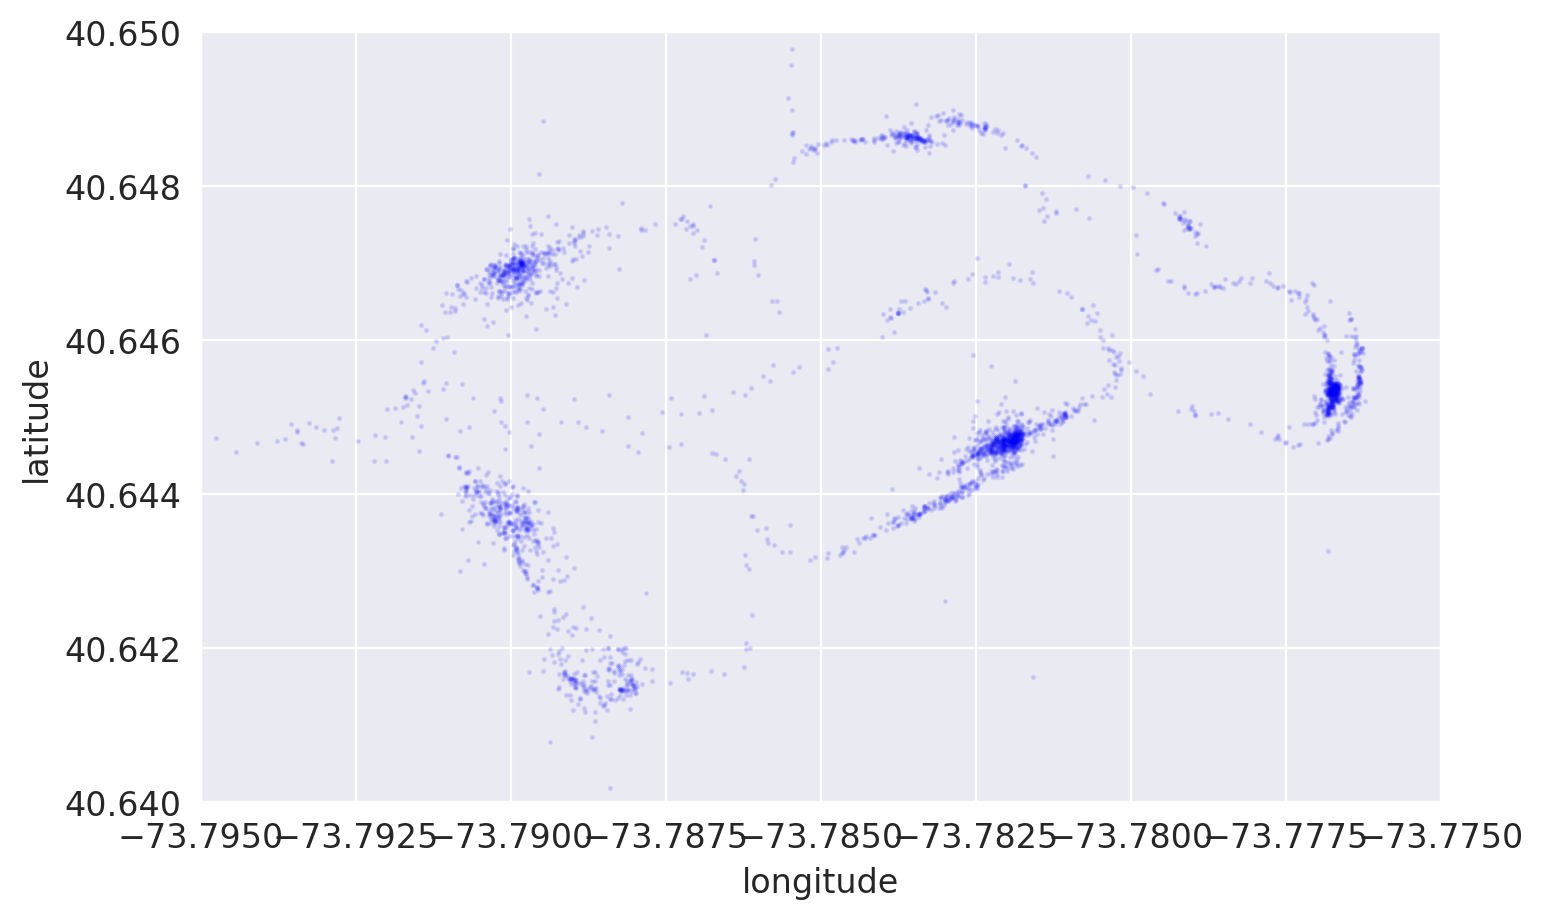

In [152]:
main_long_border = (-74, -73.95)
main_lat_border = (40.7, 40.815)

N=100000
out1_long_border = (-73.795, -73.775)
out1_lat_border = (40.64, 40.65)

plt.scatter(train_df['dropoff_longitude'].values[:N], train_df['dropoff_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.scatter(train_df['pickup_longitude'].values[:N], train_df['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(out1_lat_border)
plt.xlim(out1_long_border)
plt.show()


Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

In [153]:
train_df_essential['started_in_outliers_1'] = train_df['started_in_outliers_1']
train_df_essential['started_in_outliers_2'] = train_df['started_in_outliers_2']
train_df_essential['ended_in_outliers_1'] = train_df['ended_in_outliers_1']
train_df_essential['ended_in_outliers_2'] = train_df['ended_in_outliers_2']

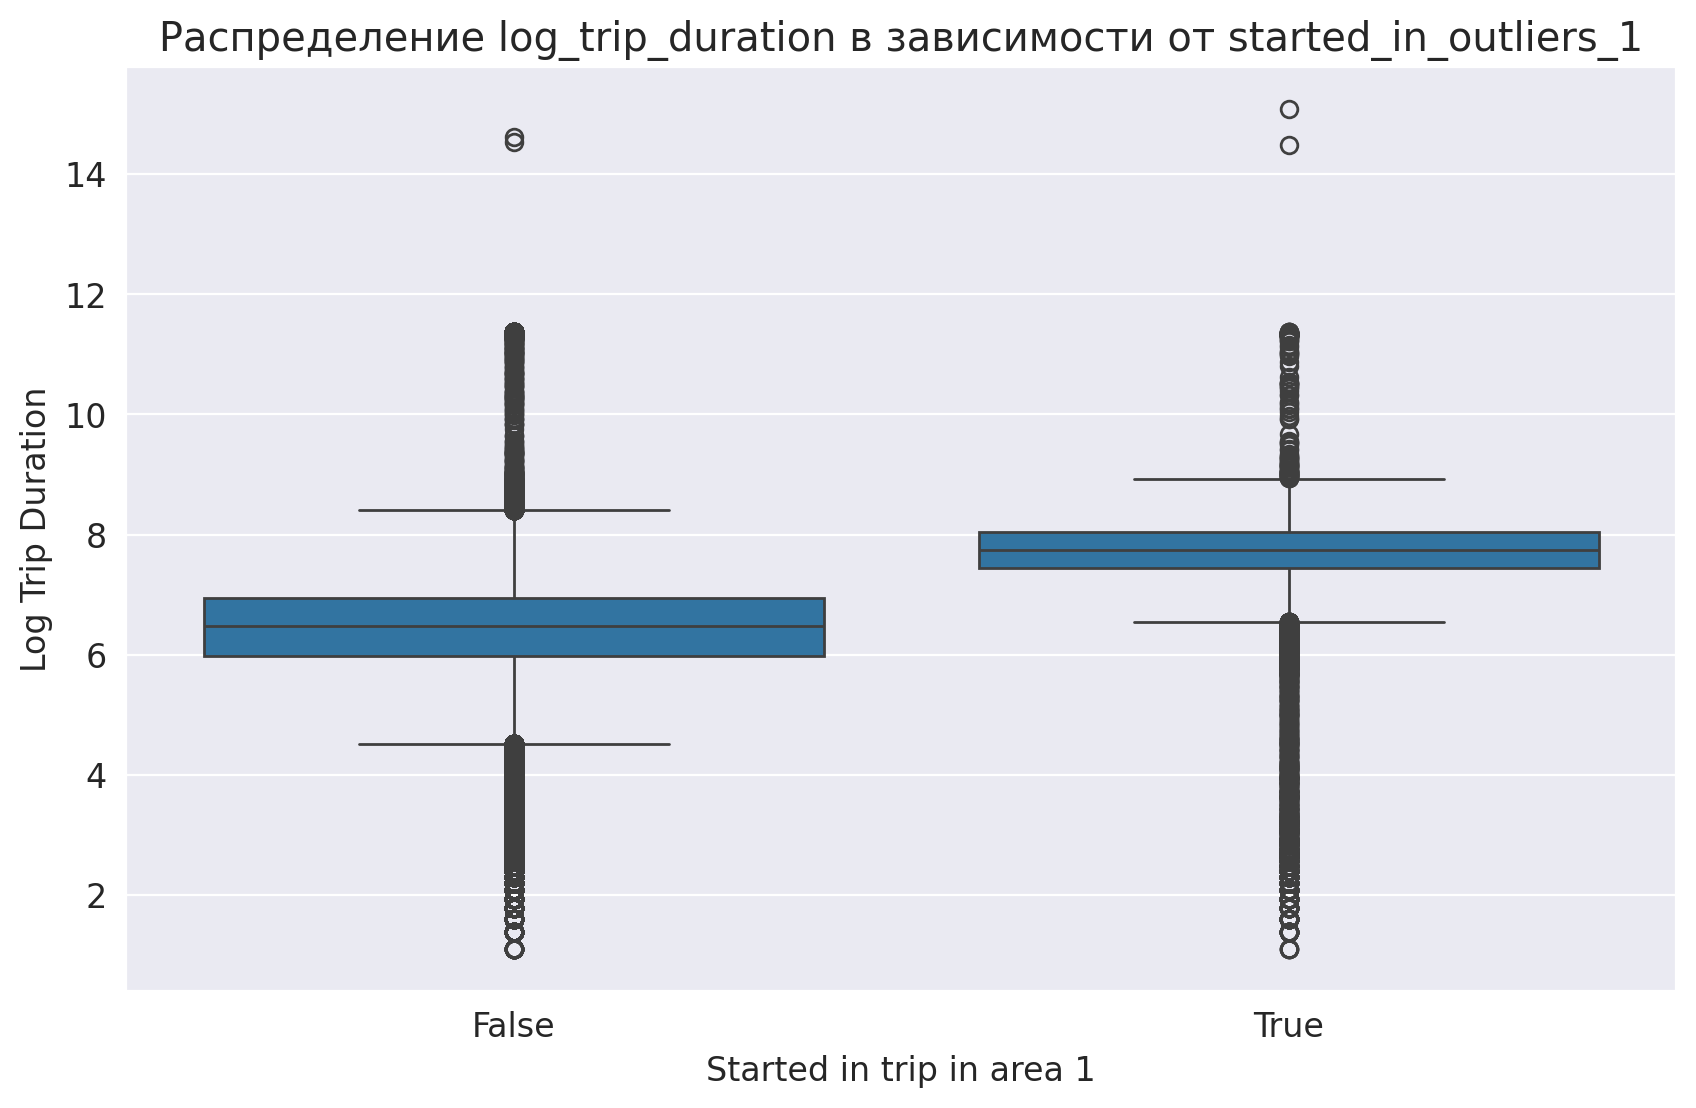

In [154]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='started_in_outliers_1', y='log_trip_duration', data=train_df_essential)

plt.title('Распределение log_trip_duration в зависимости от started_in_outliers_1')
plt.xlabel('Started in trip in area 1')
plt.ylabel('Log Trip Duration')
plt.show()

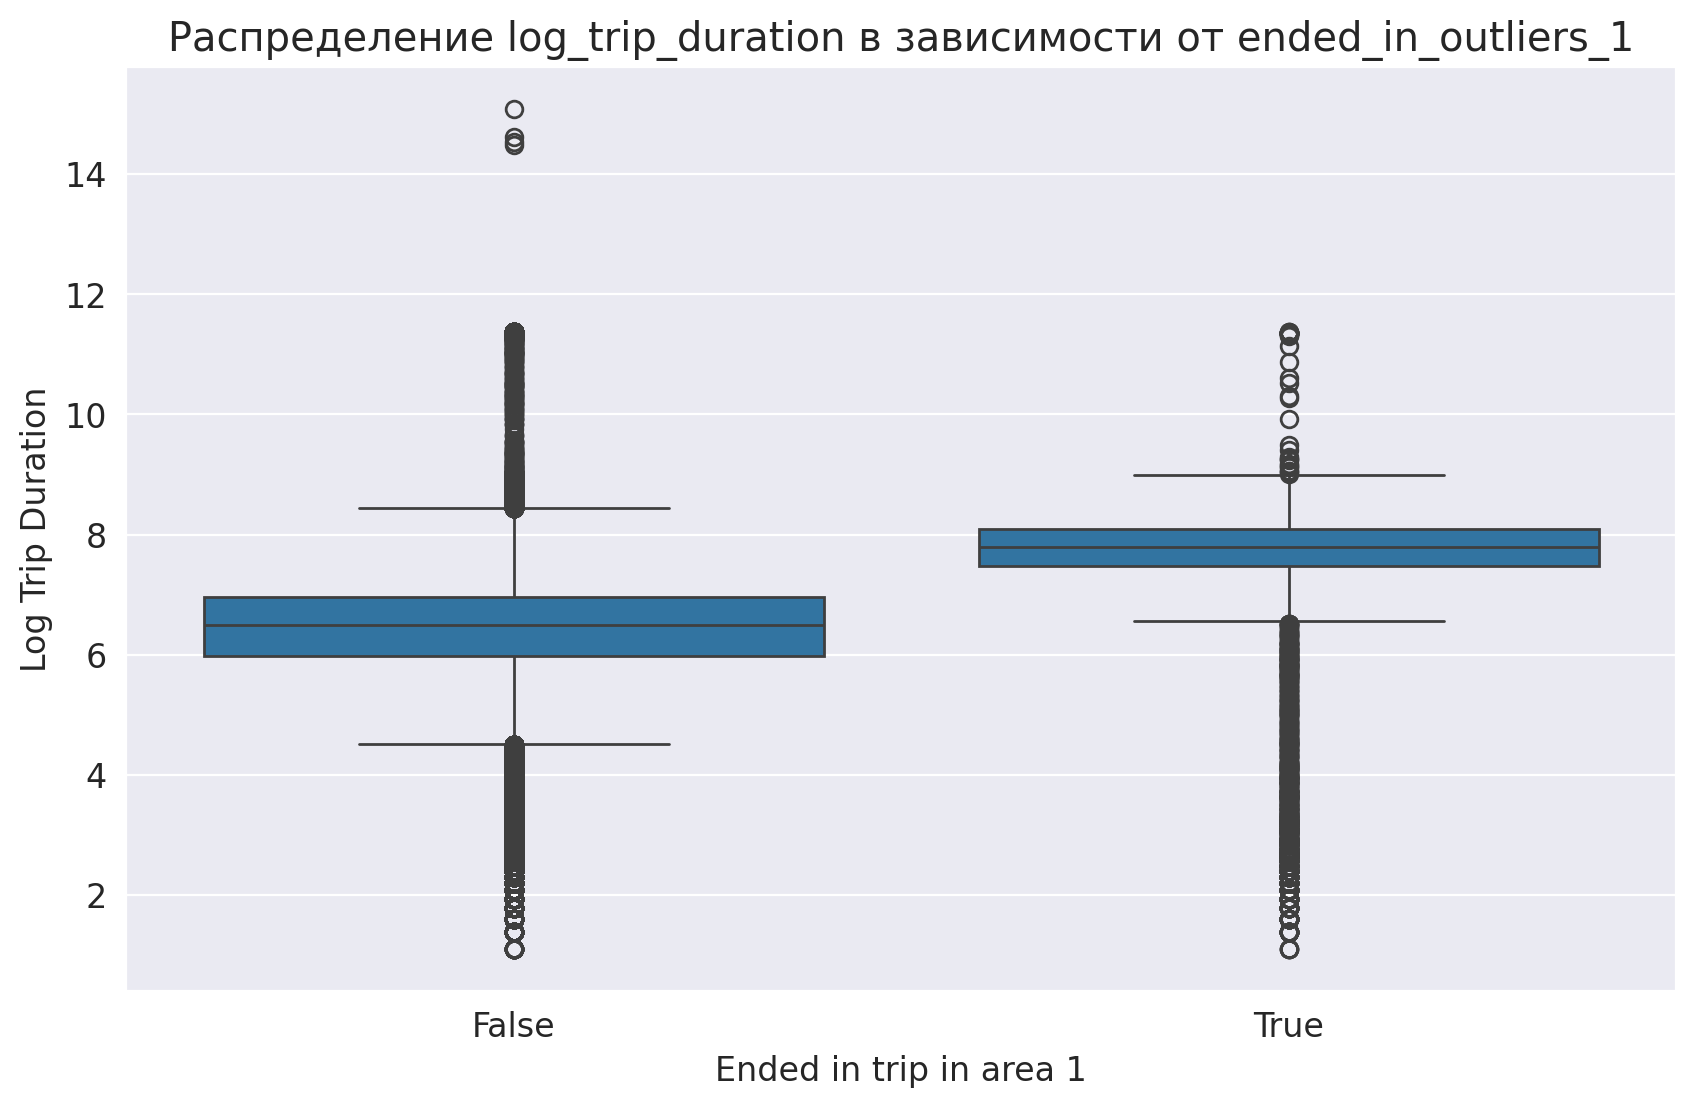

In [155]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ended_in_outliers_1', y='log_trip_duration', data=train_df_essential)

plt.title('Распределение log_trip_duration в зависимости от ended_in_outliers_1')
plt.xlabel('Ended in trip in area 1')
plt.ylabel('Log Trip Duration')
plt.show()

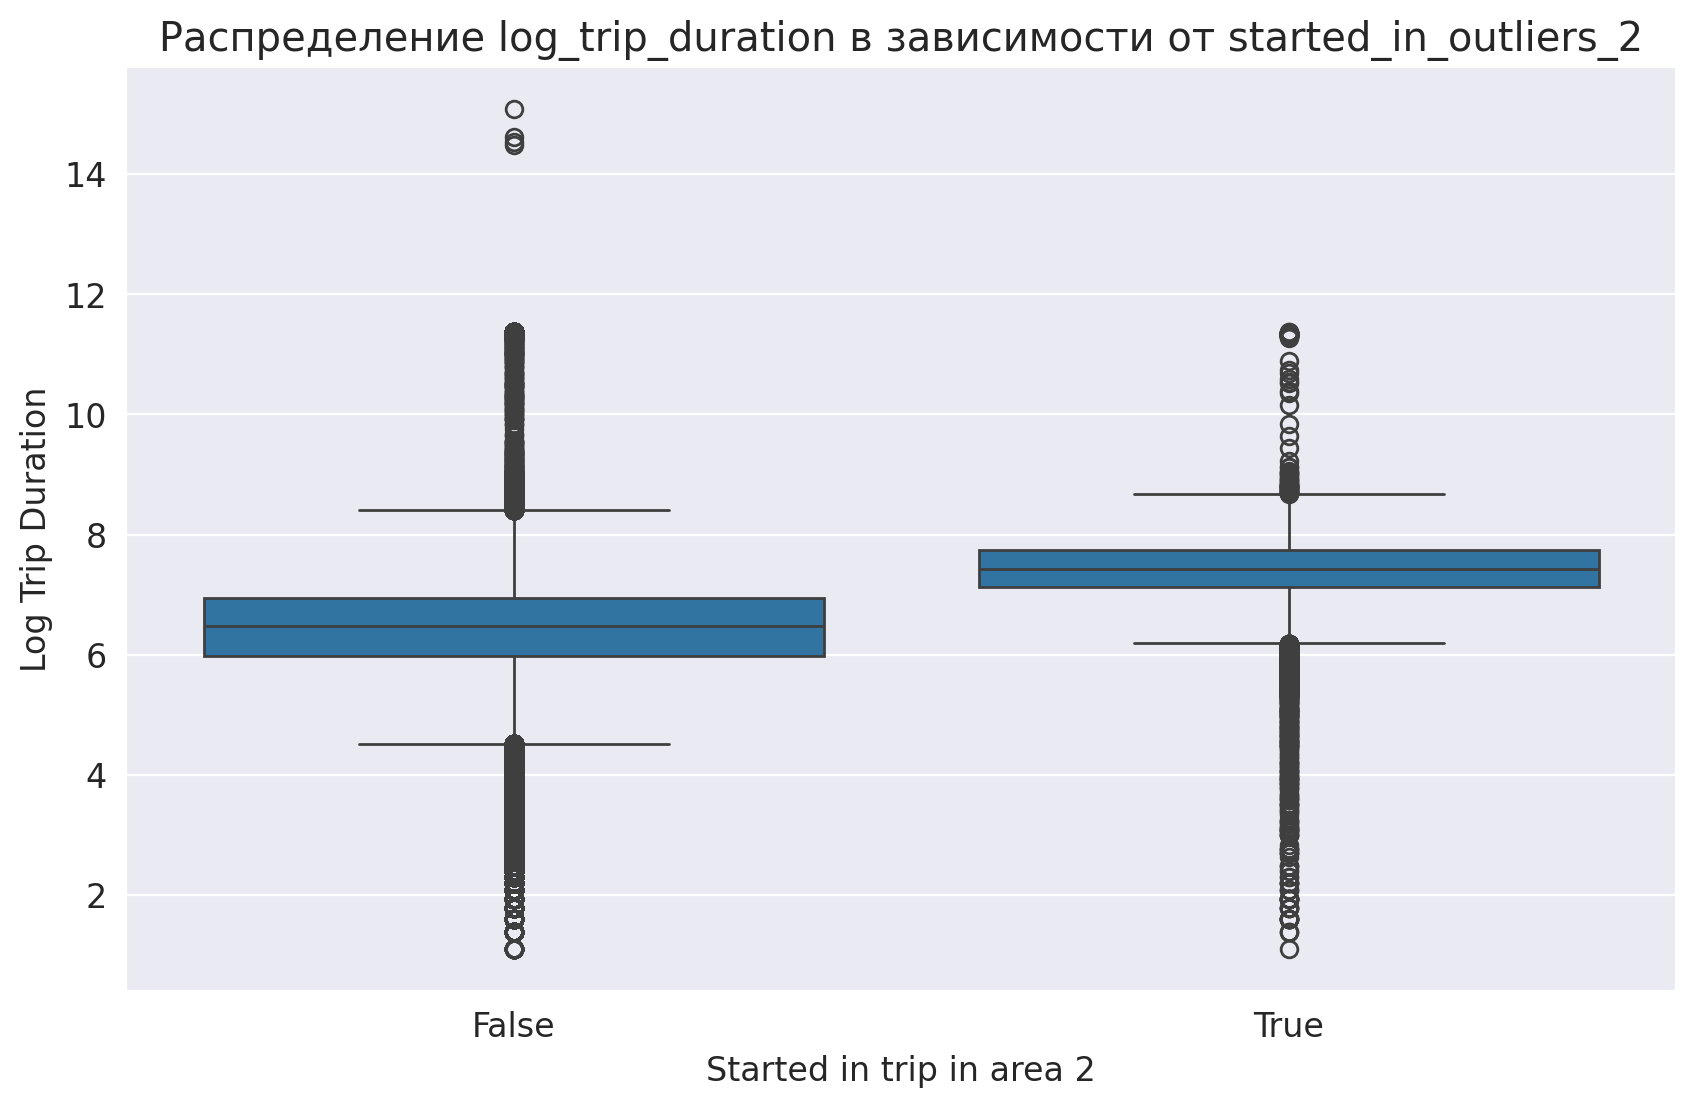

In [156]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='started_in_outliers_2', y='log_trip_duration', data=train_df_essential)

plt.title('Распределение log_trip_duration в зависимости от started_in_outliers_2')
plt.xlabel('Started in trip in area 2')
plt.ylabel('Log Trip Duration')
plt.show()

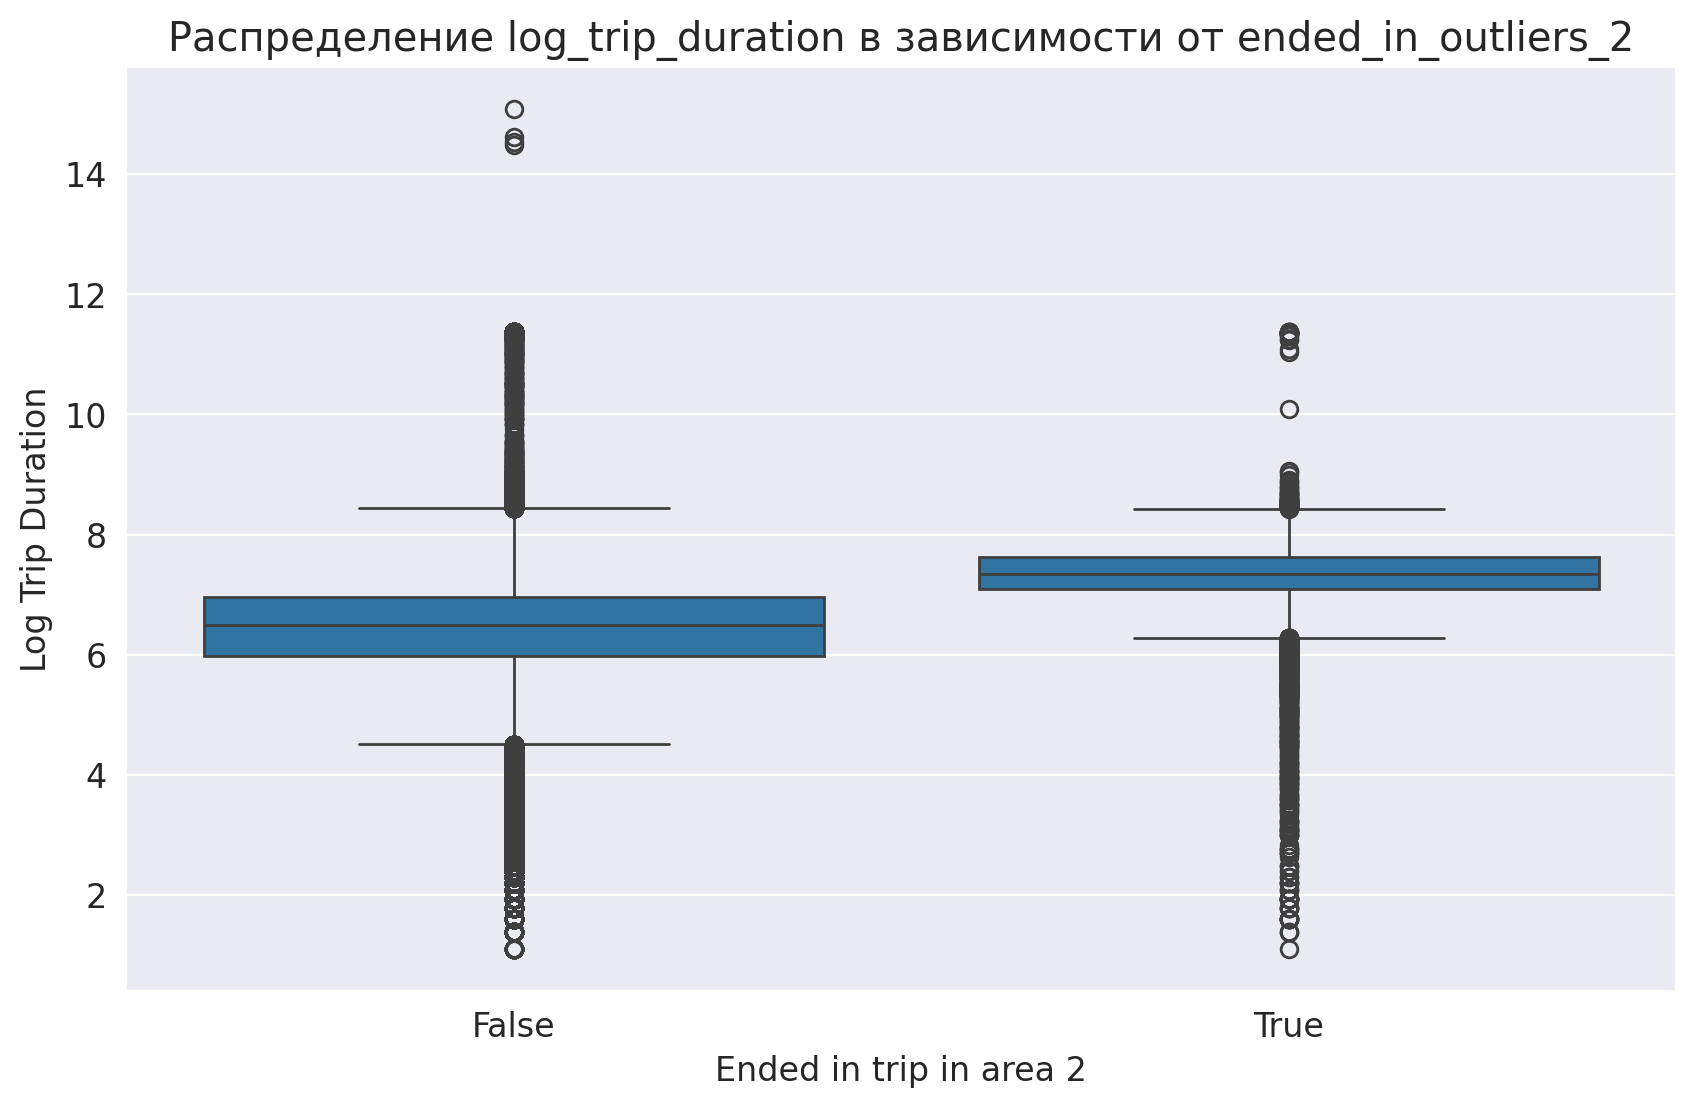

In [157]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ended_in_outliers_2', y='log_trip_duration', data=train_df_essential)

plt.title('Распределение log_trip_duration в зависимости от ended_in_outliers_2')
plt.xlabel('Ended in trip in area 2')
plt.ylabel('Log Trip Duration')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Признаки получились относительно информативными. Однако, судя по графикам, глобальных различий в случае старта и финиша поездок на выделенных участках нет.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [158]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import folium
from typing import Iterable

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rows=4, cols=3):
        self.rows = rows
        self.cols = cols

    def fit(self, X, y=None):
        X_ = X.values
        self.bottom, self.left = np.median(X_, axis=0) - X_.std(axis=0) * 1
        self.top, self.right = np.median(X_, axis=0) + X_.std(axis=0) * 1
        self.height = (self.top - self.bottom) / self.rows
        self.width = (self.right - self.left) / self.cols
        return self

    def transform(self, X):
        X_ = X.values
        c = ((X_[:, 1] - self.left) // self.width).astype(int)
        r = ((X_[:, 0] - self.bottom) // self.height).astype(int)
        n = c + r * self.cols + 1

        n[(X_[:, 1] < self.left) | (X_[:, 1] > self.right) |
          (X_[:, 0] < self.bottom) | (X_[:, 0] > self.top)] = -1
        return n.astype(int)

transformer = MapGridTransformer(rows=4, cols=3)
train_df['pickup_grid'] = transformer.fit_transform(train_df[['pickup_latitude', 'pickup_longitude']])
train_df['dropoff_grid'] = transformer.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])

train1, test1 = train_test_split(train_df[['pickup_grid', 'dropoff_grid']], test_size=0.3, random_state=10)

In [159]:
center_lat, center_lon = train_df[['pickup_latitude', 'pickup_longitude']].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

m = show_circles_on_map(
    train_df['pickup_latitude'].sample(1000),
    train_df['pickup_longitude'].sample(1000),
    color="blue"
)

for i in range(transformer.rows):
    for j in range(transformer.cols):
        bounds = [
            [transformer.bottom + i * transformer.height, transformer.left + j * transformer.width],
            [transformer.bottom + (i + 1) * transformer.height, transformer.left + (j + 1) * transformer.width]
        ]
        folium.Rectangle(
            bounds=bounds,
            color='red',
            weight=2,
            fill_opacity=0
        ).add_to(m)
m

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [160]:
category_features = [ 'is_busy', 'is_free', 'day_of_week', 'hour', 'month', 'is_anomaly','started_in_outliers_1', 'started_in_outliers_2', 'ended_in_outliers_1', 'ended_in_outliers_2']
numerical_features = ['num_day_in_the_year']

train_df_10 = train_df_essential[category_features + numerical_features].copy()
y = train_df_essential['log_trip_duration'].apply(lambda x: x if x > 1e-9 else 0)

x_train, x_valid, y_train, y_valid = train_test_split(train_df_10, y, test_size=0.3)

prep = ColumnTransformer(transformers = [
    ('categorial', OneHotEncoder(), category_features),
    ('numerical', StandardScaler(), numerical_features)
])

model = Pipeline([
    ('prep', prep),
    ('regressor', Ridge())
])

model.fit(x_train, y_train)

y_pred = model.predict(x_valid)
rmsle_value = rmsle(y_valid, y_pred)
print(f'RMSLE = {rmsle_value}')


RMSLE = 0.7410753414962614


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

`vendor_id` предоставляет информацию о провайдере. Данный показатель может оказаться полезным, так как позволяет оценить производительность каждого из провайдеров (количество принятых от него заказов), а также помогает отследить возможные аномалии и неточности, связанные с качеством связи. Наличие большого количества нетипичных данных у одного провайдера может сигнализировать о проблемах со связью и качеством геоданных.

`passenger_count` позволяет оценить спрос в каждом регионе в конкретный момент времени. Это может помочь при распределении автомобилей по разным регионам, позволяя направить вместительные машины в районы с максимальным показателем `passenger_count`.

`store_and_fwd_flag` позволяет оценивать качество связи в разных районах, что дает понимание о возможных проблемах и задержках при построении маршрута.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [161]:
print(f"Количество уникальных значений у vendor_id: {train_df['vendor_id'].nunique()}")
print(f"Количество уникальных значений у passenger_count: {train_df['passenger_count'].nunique()}")
print(f"Количество уникальных значений у store_and_fwd_flag: {train_df['store_and_fwd_flag'].nunique()}")


Количество уникальных значений у vendor_id: 2
Количество уникальных значений у passenger_count: 10
Количество уникальных значений у store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

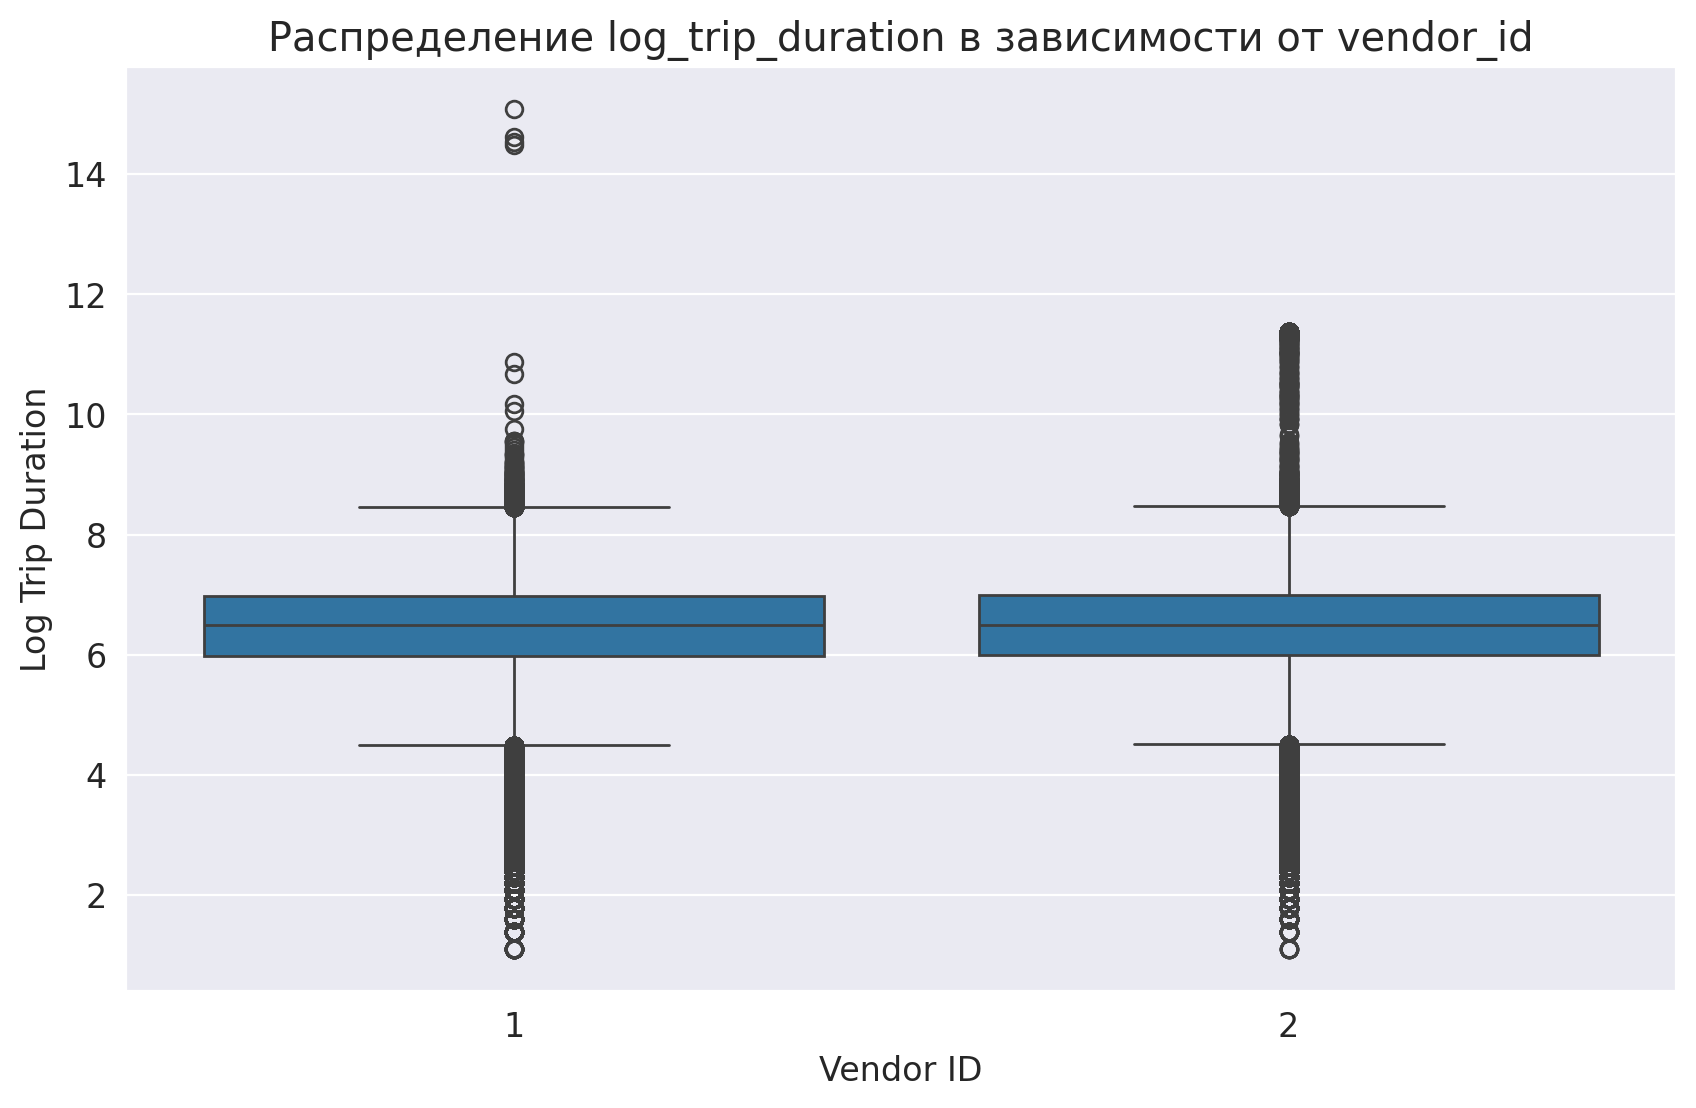

In [162]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='vendor_id', y='log_trip_duration', data=train_df)

plt.title('Распределение log_trip_duration в зависимости от vendor_id')
plt.xlabel('Vendor ID')
plt.ylabel('Log Trip Duration')
plt.show()

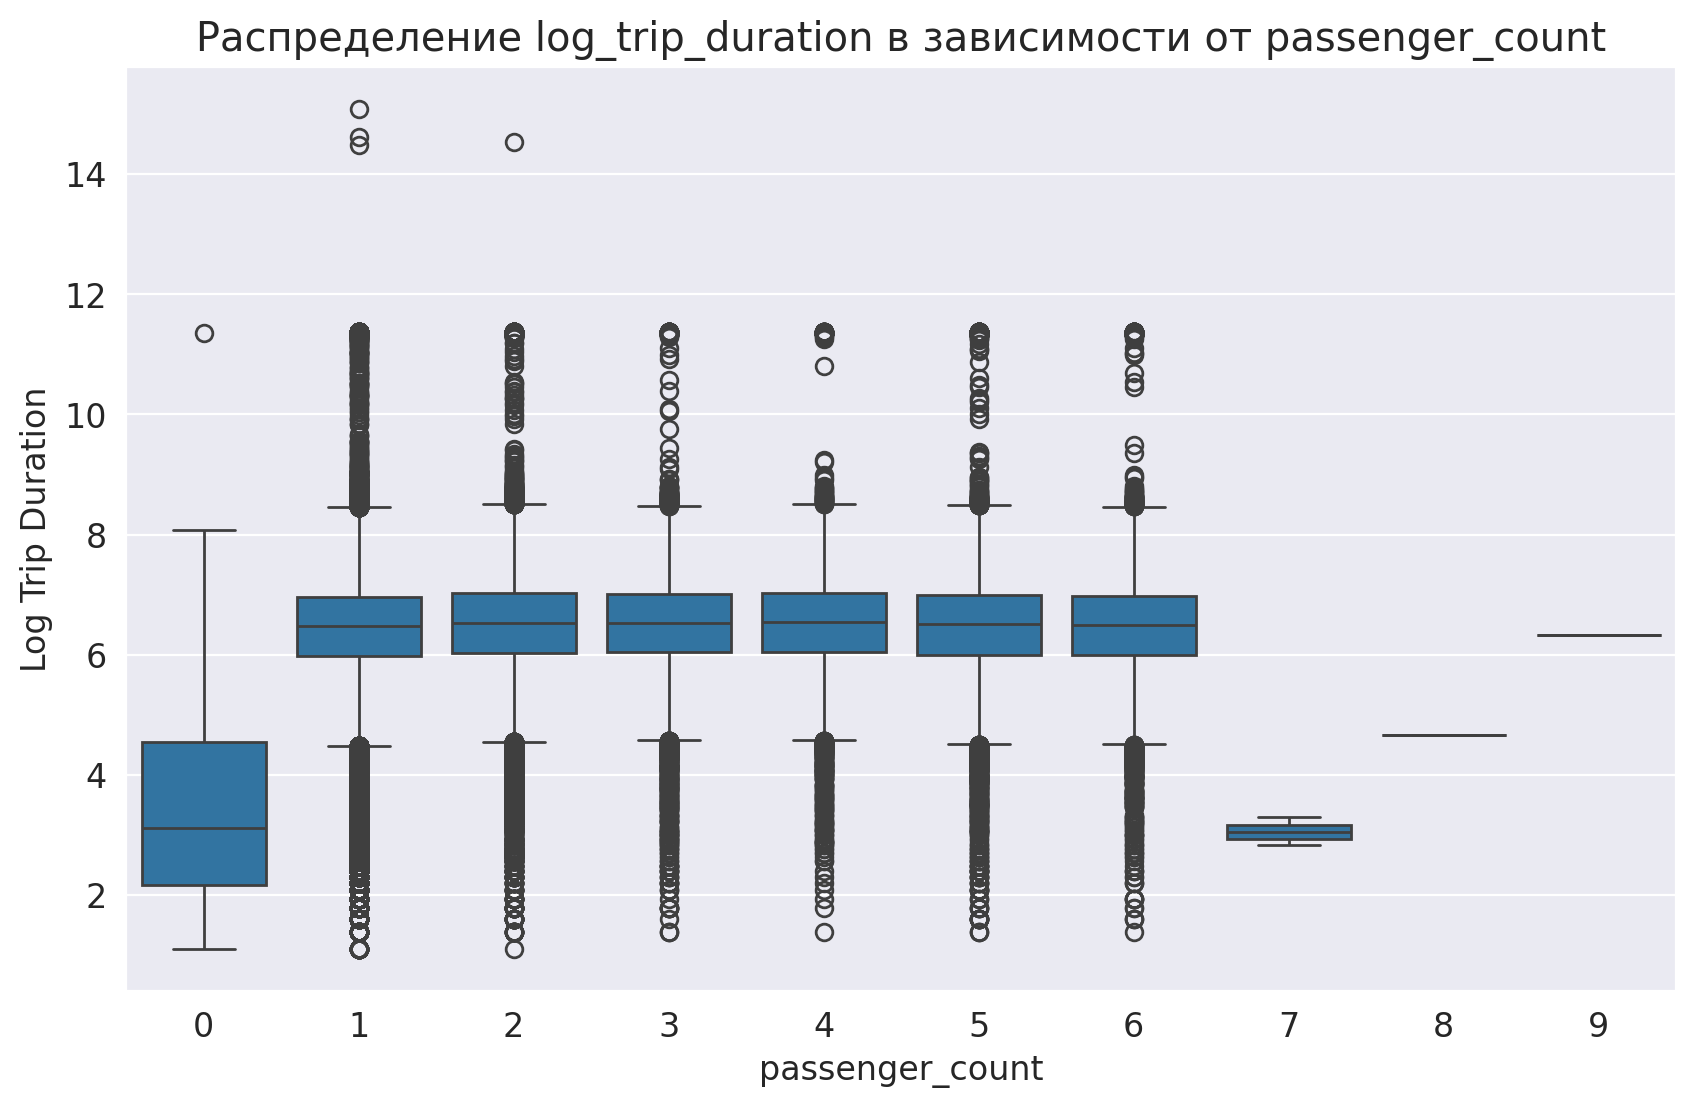

In [163]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='log_trip_duration', data=train_df)

plt.title('Распределение log_trip_duration в зависимости от passenger_count')
plt.xlabel('passenger_count')
plt.ylabel('Log Trip Duration')
plt.show()

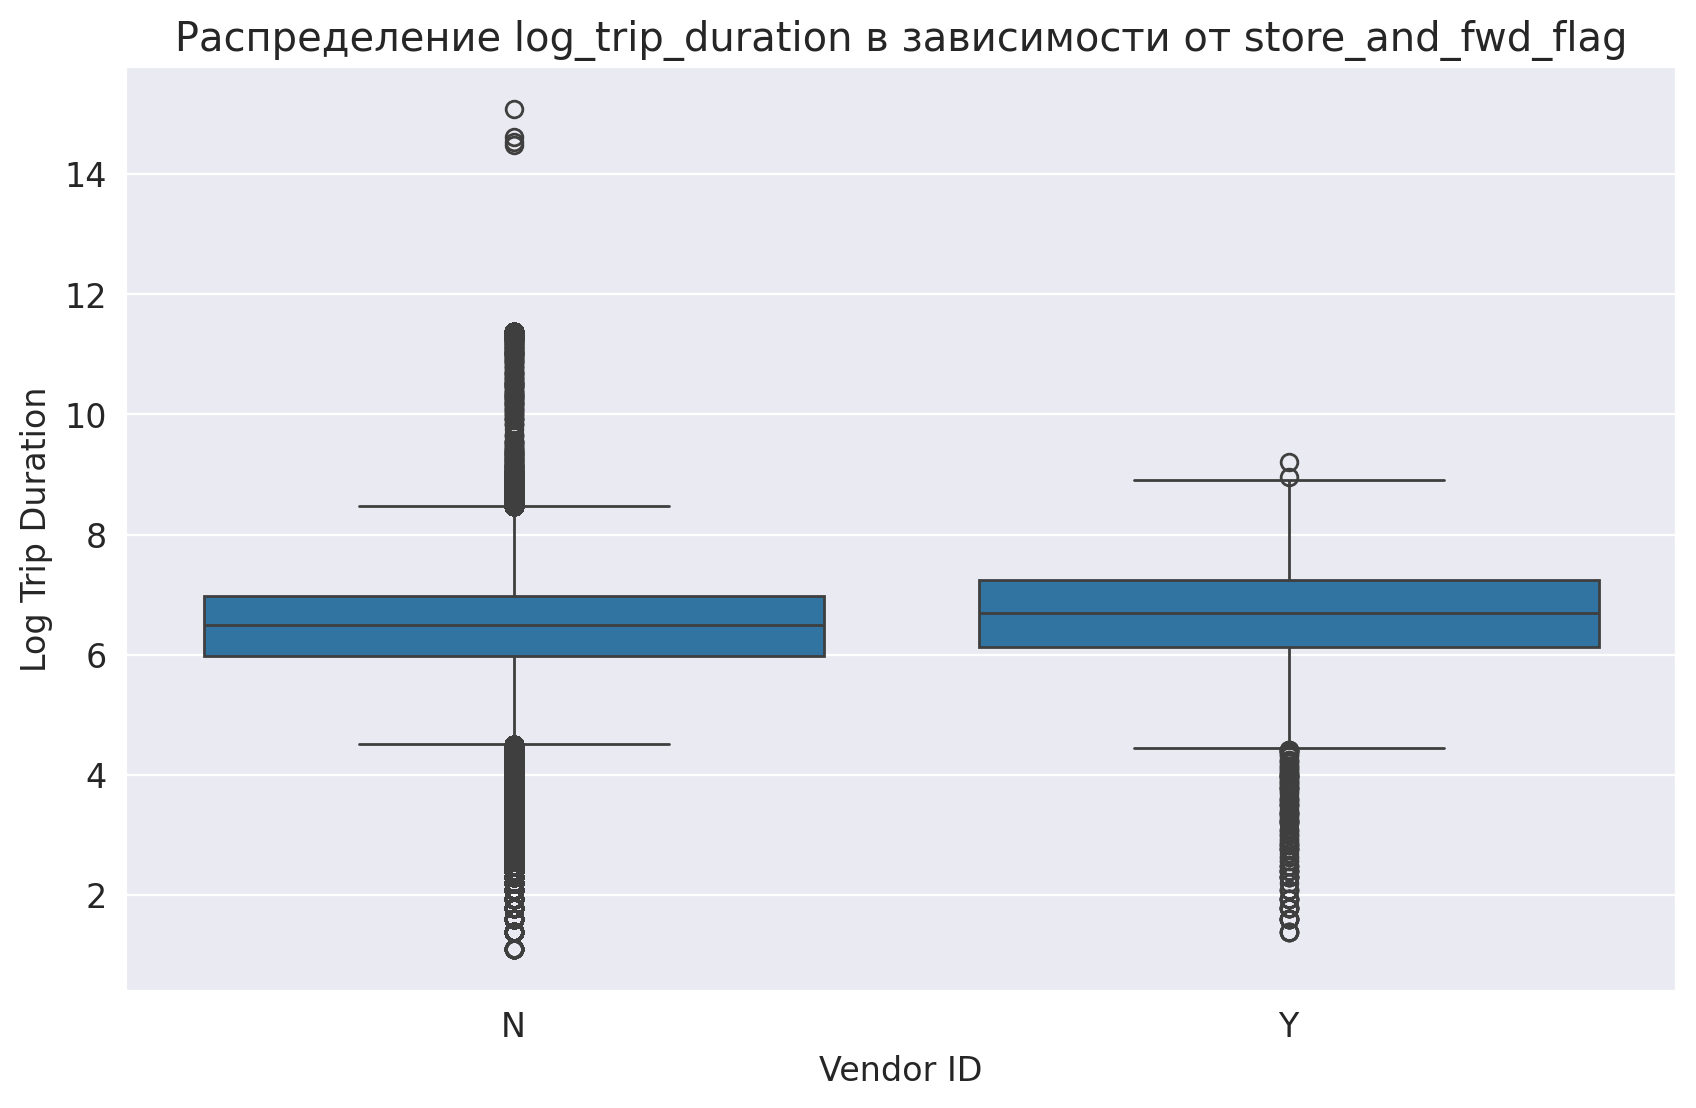

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=train_df)

plt.title('Распределение log_trip_duration в зависимости от store_and_fwd_flag')
plt.xlabel('Vendor ID')
plt.ylabel('Log Trip Duration')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [165]:
train_df['vendor_id'] = train_df['vendor_id'].replace({1: 0, 2: 1})
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})
train_df.head()

<ipython-input-165-d0c2be722651>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})


id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          1 2016-03-14 17:24:55                1   
1  id2377394          0 2016-06-12 00:43:35                1   
2  id3858529          1 2016-01-19 11:35:24                1   
3  id3504673          1 2016-04-06 19:32:31                1   
4  id2181028          1 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

   store_and_fwd_flag  trip_duration  ...  hour  month num_day_in_the_year  \
0                   0            455  ...    17      3                  74   
1                   0            663  ...     0      6                 164   
2                   0           2124  ...    11      1                  19   
3                   0            429  ...    19      4                  97   
4                   0            435  ...    13      3                  86   

   is_anomaly  started_in_outliers_1  ended_in_outliers_1  \
0           0                  False                False   
1           0                  False                False   
2           0                  False                False   
3           0                  False                False   
4           0                  False                False   

   started_in_outliers_2  ended_in_outliers_2  pickup_grid  dropoff_grid  
0                  False                False            8             8  
1                  False                False            5             2  
2                  False                False            8            -1  
3                  False                False           -1            -1  
4                  False                False           -1            11  

[5 rows x 23 columns]

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Судя по графикам:

1) `vendor_id` не окажет большого влияния на качество модели, так как графики распределения таргета для разных провайдеров примерно повторяют друг друга.

2) `passenger_count` может быть полезен для модели, однако результаты при значениях `passenger_count` от 1 до 6 практически не имеют различий. Для упрощения модели эти значения можно объединить в 1 признак.

3) `store_and_fwd_flag` может оказать влияние, но не будет сильным признаком, так как медиана и большинство значений таргета лежат в одном и том же диапазоне при положительном и нулевом значении этого признака.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [166]:
train_df_essential = pd.concat([train_df_essential, train_df[['passenger_count', 'vendor_id', 'store_and_fwd_flag']]], axis = 1)

In [168]:
category_features.append('vendor_id')
category_features.append('store_and_fwd_flag')
numerical_features.append('passenger_count')

In [169]:
y = train_df_essential['log_trip_duration'].apply(lambda x: x if x > 1e-9 else 0)
x_train, x_valid, y_train, y_valid = train_test_split(train_df_essential, y, test_size=0.3)

prep = ColumnTransformer(transformers = [
    ('categorial', OneHotEncoder(), category_features),
    ('numerical', StandardScaler(), numerical_features)
])

model = Pipeline([
    ('prep', prep),
    ('regressor', Ridge())
])

model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
rmsle_value = rmsle(y_valid, y_pred)
print(f'RMSLE = {rmsle_value}')

RMSLE = 0.7421094878369118


In [170]:
train_df_essential['id'] = train_df['id']
train_df_essential.head()

day_of_week  hour  month  is_anomaly  num_day_in_the_year  \
0      Monday    17      3           0                   74   
1      Sunday     0      6           0                  164   
2     Tuesday    11      1           0                   19   
3   Wednesday    19      4           0                   97   
4    Saturday    13      3           0                   86   

   log_trip_duration  trip_duration    haversine  log_haversine     speed  \
0           6.124683            455  1498.522849       7.312235  3.293457   
1           6.499787            663  1805.509663       7.498598  2.723242   
2           7.661998           2124  6385.107315       8.761724  3.006171   
3           6.066108            429  1485.500475       7.303507  3.462705   
4           6.079933            435  1188.590101       7.080523  2.732391   

   is_busy  is_free  started_in_outliers_1  started_in_outliers_2  \
0        1        0                  False                  False   
1        0        1                  False                  False   
2        1        0                  False                  False   
3        0        0                  False                  False   
4        0        0                  False                  False   

   ended_in_outliers_1  ended_in_outliers_2  passenger_count  vendor_id  \
0                False                False                1          1   
1                False                False                1          0   
2                False                False                1          1   
3                False                False                1          1   
4                False                False                1          1   

   store_and_fwd_flag         id  
0                   0  id2875421  
1                   0  id2377394  
2                   0  id3858529  
3                   0  id3504673  
4                   0  id2181028

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [171]:
train_df_essential.head()

day_of_week  hour  month  is_anomaly  num_day_in_the_year  \
0      Monday    17      3           0                   74   
1      Sunday     0      6           0                  164   
2     Tuesday    11      1           0                   19   
3   Wednesday    19      4           0                   97   
4    Saturday    13      3           0                   86   

   log_trip_duration  trip_duration    haversine  log_haversine     speed  \
0           6.124683            455  1498.522849       7.312235  3.293457   
1           6.499787            663  1805.509663       7.498598  2.723242   
2           7.661998           2124  6385.107315       8.761724  3.006171   
3           6.066108            429  1485.500475       7.303507  3.462705   
4           6.079933            435  1188.590101       7.080523  2.732391   

   is_busy  is_free  started_in_outliers_1  started_in_outliers_2  \
0        1        0                  False                  False   
1        0        1                  False                  False   
2        1        0                  False                  False   
3        0        0                  False                  False   
4        0        0                  False                  False   

   ended_in_outliers_1  ended_in_outliers_2  passenger_count  vendor_id  \
0                False                False                1          1   
1                False                False                1          0   
2                False                False                1          1   
3                False                False                1          1   
4                False                False                1          1   

   store_and_fwd_flag         id  
0                   0  id2875421  
1                   0  id2377394  
2                   0  id3858529  
3                   0  id3504673  
4                   0  id2181028

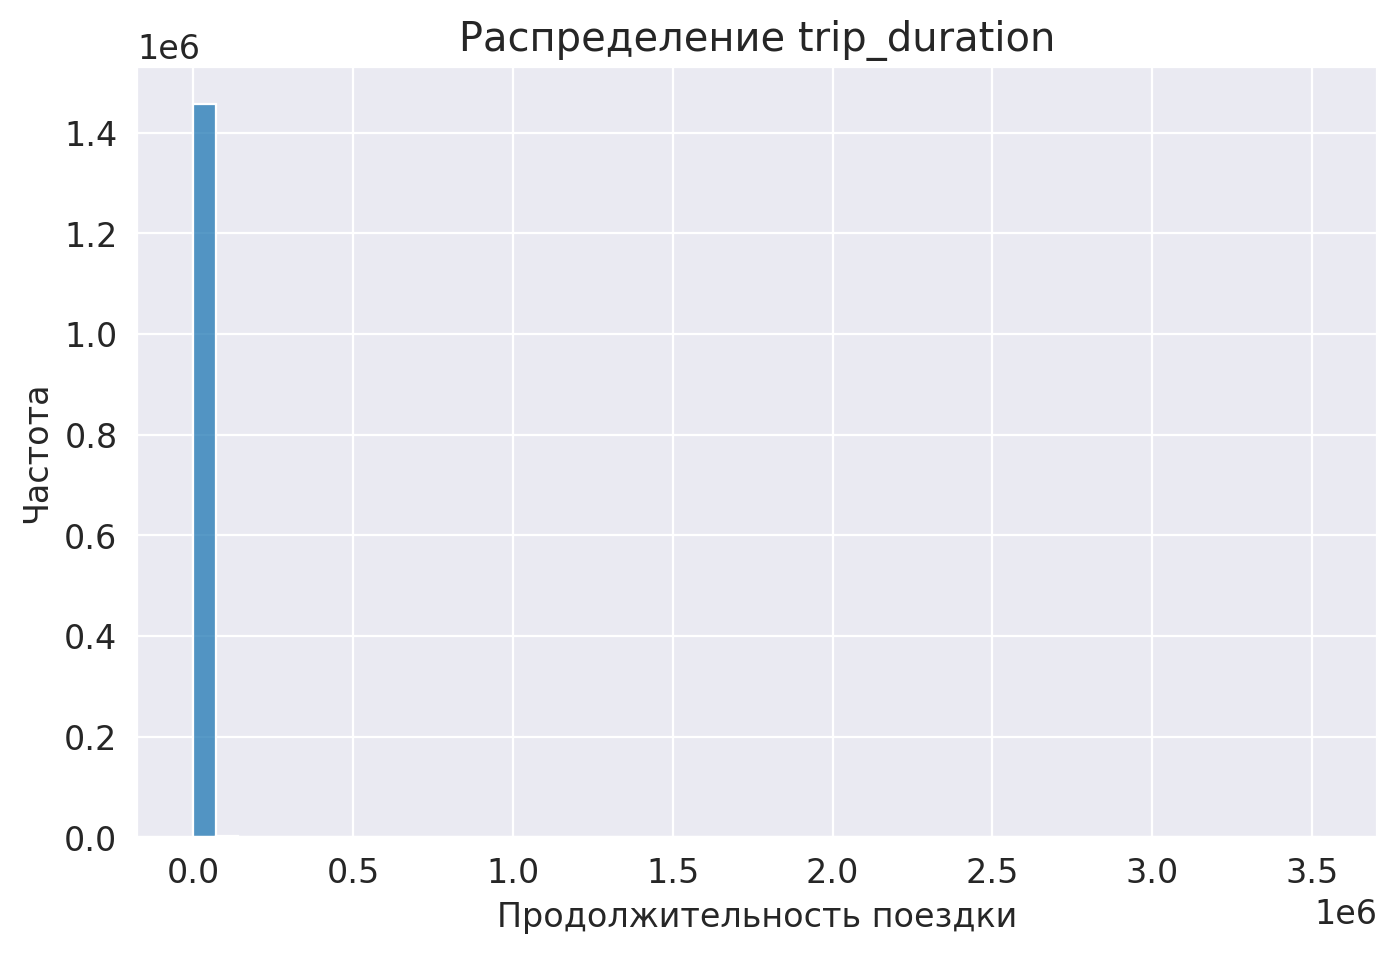

In [172]:
sns.histplot(train_df_essential['trip_duration'], bins=50, kde=False)

plt.title('Распределение trip_duration')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Частота')

plt.show()

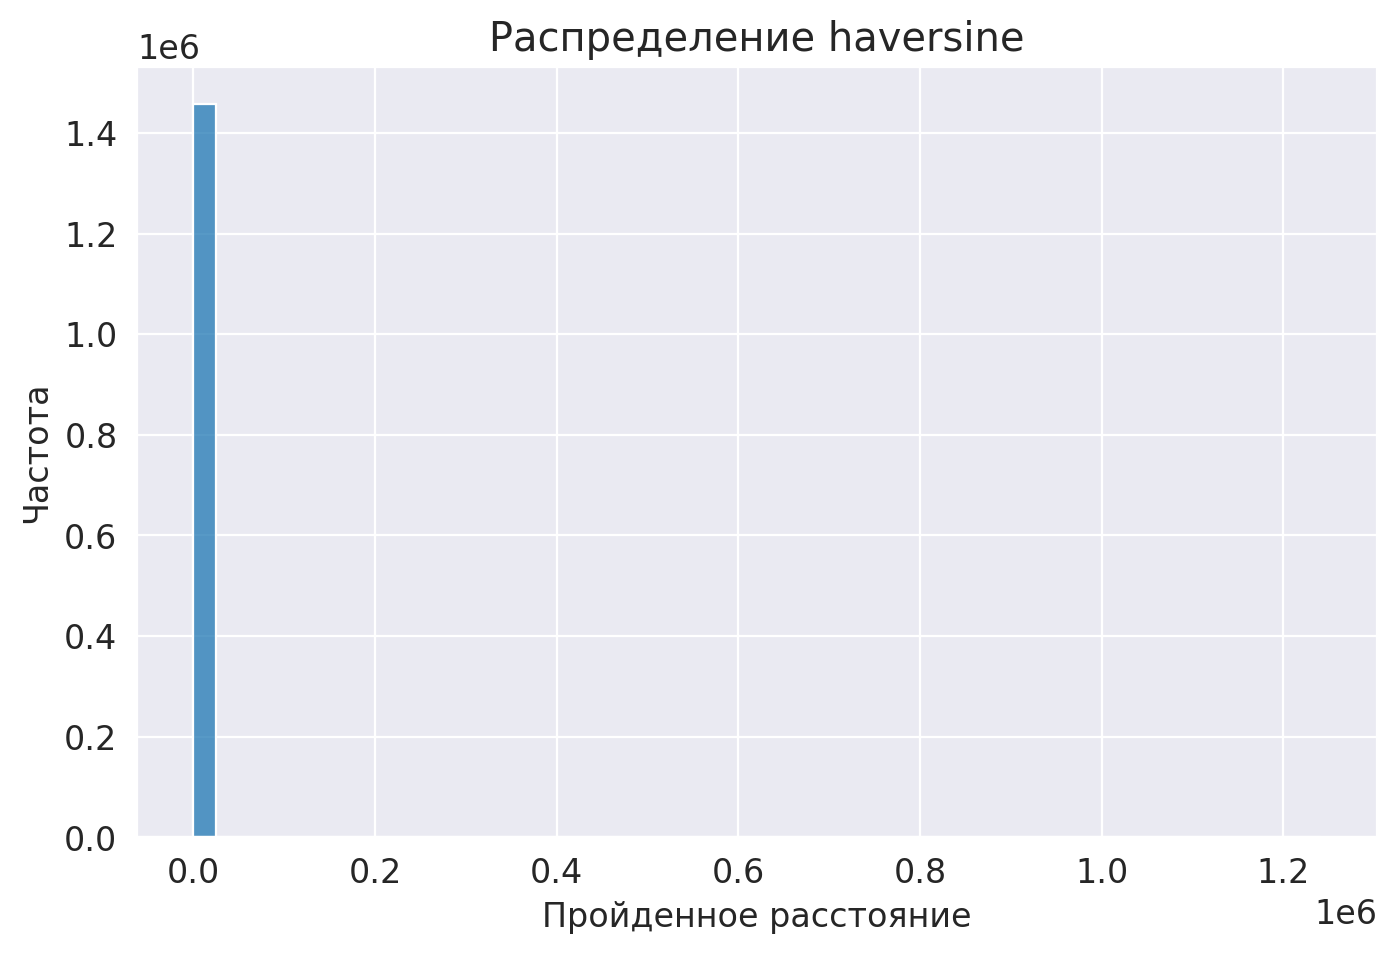

In [173]:
sns.histplot(train_df_essential['haversine'], bins=50, kde=False)

plt.title('Распределение haversine')
plt.xlabel('Пройденное расстояние')
plt.ylabel('Частота')

plt.show()

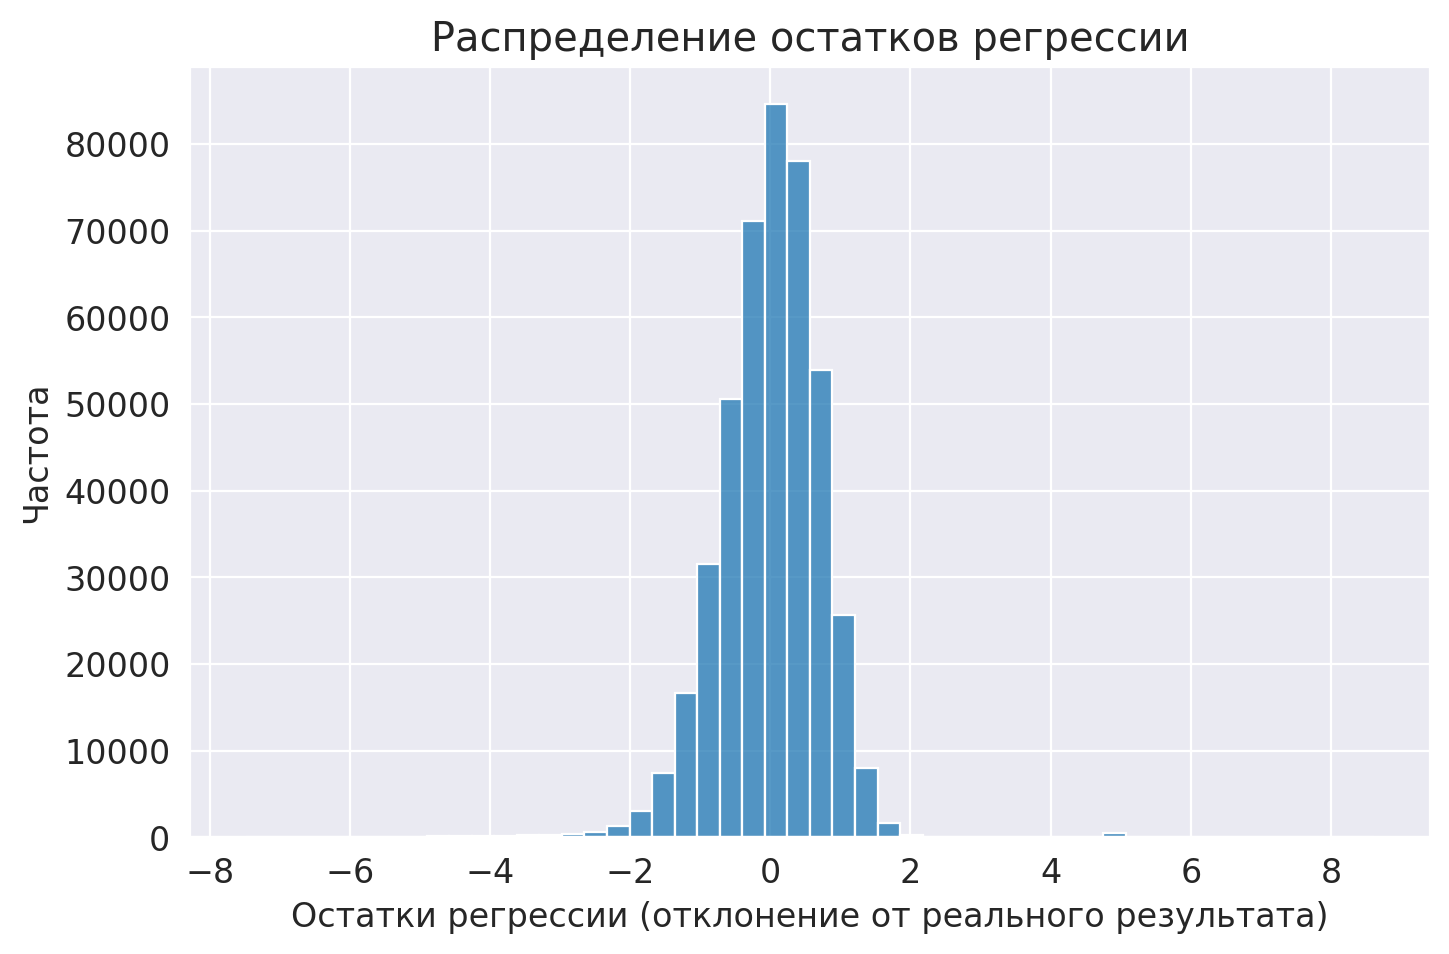

In [174]:
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
res = y_valid - y_pred

sns.histplot(res, bins=50, kde=False)

plt.title('Распределение остатков регрессии')
plt.xlabel('Остатки регрессии (отклонение от реального результата)')
plt.ylabel('Частота')

plt.show()

In [175]:
# Удалим выбросы по каждому из перечисленных признаков:
outlier_condition = (train_df_essential['trip_duration'] > 0.5 * 1e6) | (train_df_essential['haversine'] > 0.2*1e6) | (res.abs() > 5)
ids_to_remove = train_df_essential[outlier_condition]['id']
train_df_essential = train_df_essential[train_df_essential['trip_duration'] <= 0.5 * 1e6]
train_df = train_df[~train_df['id'].isin(ids_to_remove)]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

Если `passenger_count` > 6 ⇒ `passenger_count` = 7 для любых значений

In [176]:
train_df_essential['passenger_count'] = train_df_essential['passenger_count'].apply(lambda x: 7 if x > 6 else x)

In [177]:
train_df_essential['remote_area_1'] = train_df_essential['started_in_outliers_1'] | train_df_essential['ended_in_outliers_1']
train_df_essential['remote_area_2'] = train_df_essential['started_in_outliers_2'] | train_df_essential['ended_in_outliers_2']
train_df_essential = train_df_essential.drop(columns = ['started_in_outliers_1', 'started_in_outliers_2', 'ended_in_outliers_1', 'ended_in_outliers_2'])

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [180]:
category_features = [ 'is_busy', 'is_free', 'day_of_week', 'hour', 'month', 'is_anomaly','remote_area_1', 'remote_area_2']
numerical_features = []

y = train_df_essential['log_trip_duration'].apply(lambda x: x if x > 1e-9 else 0)
x_train, x_valid, y_train, y_valid = train_test_split(train_df_essential, y, test_size=0.3)

prep = ColumnTransformer(transformers = [
    ('categorial', OneHotEncoder(), category_features),
    ('numerical', StandardScaler(), numerical_features)
])

model = Pipeline([
    ('prep', prep),
    ('regressor', Ridge())
])

model.fit(x_train, y_train)

y_pred = model.predict(x_valid)
rmsle_value = rmsle(y_valid, y_pred)
print(f'RMSLE = {rmsle_value}')


RMSLE = 0.7323614956151943


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [181]:
num_features_before = train_df_essential.shape[1]
print("Количество признаков до кодирования:", num_features_before)
train_df_encoded = pd.get_dummies(train_df_essential, columns=category_features)

num_features_after = train_df_encoded.shape[1]
print("Количество признаков после кодирования:", num_features_after)

Количество признаков до кодирования: 18
Количество признаков после кодирования: 57


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?
В моем случае метод Ridge получился более подходящим (0.74 < 0.79)

In [182]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ('prep', prep),
    ('regressor', Lasso())
])

model.fit(x_train, y_train)

y_pred = model.predict(x_valid)
rmsle_value = rmsle(y_valid, y_pred)
print(f'RMSLE = {rmsle_value}')

RMSLE = 0.7902292142128367


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [186]:
from sklearn.linear_model import RidgeCV, LassoCV
x_train, x_tmp, y_train, y_tmp = train_test_split(train_df_essential, y, test_size=0.4, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)


alpha_range = np.logspace(-4, 4, 50)
ridge_model = Pipeline([
    ('prep', prep),
    ('regressor', RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_log_error', cv=5))
])
ridge_model.fit(x_train, y_train)

lasso_model = Pipeline([
    ('prep', prep),
    ('regressor', LassoCV(alphas=alpha_range, cv=5, random_state=42))
])
lasso_model.fit(x_train, y_train)

best_alpha_ridge = ridge_model.named_steps['regressor'].alpha_
best_alpha_lasso = lasso_model.named_steps['regressor'].alpha_

print(f'Best alpha for Ridge: {best_alpha_ridge}')
print(f'Best alpha for Lasso: {best_alpha_lasso}')

y_valid_pred_ridge = ridge_model.predict(x_valid)
y_valid_pred_lasso = lasso_model.predict(x_valid)

rmsle_ridge = rmsle(y_valid, y_valid_pred_ridge)
rmsle_lasso = rmsle(y_valid, y_valid_pred_lasso)

print(f'Ridge RMSLE on validation set: {rmsle_ridge}')
print(f'Lasso RMSLE on validation set: {rmsle_lasso}')

Best alpha for Ridge: 0.0062505519252739694
Best alpha for Lasso: 0.0001
Ridge RMSLE on validation set: 0.7362969201102529
Lasso RMSLE on validation set: 0.7363047504441458


Сохраните наилучшее значение, как бенчмарк на будущее

In [187]:
if rmsle_ridge < rmsle_lasso:
  best_model = ridge_model
else:
  best_model = lasso_model

y_test_pred = best_model.predict(x_test)
rmsle_test = rmsle(y_test, y_test_pred)
if rmsle_ridge < rmsle_lasso:
  print(f'Best model: Ridge')
  print(f'RMSLE on test: {rmsle_test}')
else:
  print(f'Best model: Lasso')
  print(f'RMSLE on test: {rmsle_test}')


Best model: Ridge
RMSLE on test: 0.7354059151773548


In [184]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
best_rmsle = 0.7354059151773548

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [185]:
zeros = []
for alpha in np.logspacealpha_range:
    reg = Lasso(alpha)
    reg.fit(x_train, y_train)
    zeros.append(np.sum(reg.coef_ == 0))


AttributeError: module 'numpy' has no attribute 'logspacealpha_range'

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.